In [62]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt, cm, colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

sns.set(style="darkgrid")
sns.set(style="darkgrid")
from matplotlib import pyplot as plt, cm, colors
from tqdm.notebook import tqdm

import glob
import os.path as ospath
import os
from sys import executable
from subprocess import check_output
from PyQt5.QtWidgets import QFileDialog, QApplication
from IPython.display import HTML
import re

from scipy import optimize
from scipy.spatial import distance
from scipy import linalg
from scipy import signal
from scipy import stats
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy import interpolate
from sklearn.neighbors import NearestNeighbors as NN
from scipy.signal import find_peaks


from picasso.picasso import io
from picasso.picasso.postprocess import link, compute_dark_times
from picasso.picasso.render import render
from picasso.picasso.gui.render import estimate_kinetic_rate, fit_cum_exp
from picasso.picasso.lib import append_to_rec
import warnings




In [63]:
# define colors:
blue = "#4C72B0"
orange = "#DD8452"
red = "#C44E52"
gray = "#90A8CE"


def OpenFileDialog():
    file = check_output([executable, __file__])
    return file.strip()


def gui_fname(dir=None):
    """
    Select a file via a dialog and return the file name.
    """
    if dir is None: 
        dir ="./"

    app = QApplication([dir])
    fname = QFileDialog.getExistingDirectory(None, "Select a folder...", 
            dir)
    if isinstance(fname, tuple):
        return fname[0]
    else: 
        return str(fname)


def load_files(dirname):
    
    os.chdir(dirname)
    files = glob.glob("*.hdf5")
    
    if files:
        print("{} HDF5 files found.".format(len(files)))
    else:
        print("No HDF5 files found at: {}".format(dirname))
            
    return files


def load_data(path):

    data, info = io.load_locs(path)
    try:
        pixelsize = info[1]["Pixelsize"]
    except:  
        print("No pixelsize found in yaml file. Default 130 nm used.")
  

    # convert px to nm
    data.x *= pixelsize
    data.y *= pixelsize
    data.x_pick_rot *= pixelsize
    data.y_pick_rot *= pixelsize
    
    return data, info, pixelsize


def load_ring_data_df(dirname, filename):
    file = ospath.join(dirname, filename)

    try: 
        df = pd.read_pickle(file)
    except FileNotFoundError:
        print("No results of previously analyzed datasets were detected.")
        return None
    else: 
        print("Results of previously analyzed datasets were detected.")
        return df
        

def identify_new_files(files, df_ring_data):
    """
    Identify which files have already been analyzed previously. 
    Return list of new files for processing
    """
    new_files = []
    for file in files:
        if file not in df_ring_data['filename1'].values and file not in df_ring_data['filename2'].values:
            new_files.append(file)
    
    n_old = len(files)-len(new_files)
    n_new = len(new_files)
    if n_old == 1:
        print(" {} HDF5 file was previously analyzed.".format(n_old))
    else: 
        print(" {} HDF5 files were previously analyzed.".format(n_old))
        
    if n_new == 1:
        print(" {} HDF5 file is new and will be analyzed.".format(n_new))
    else: 
        print(" {} HDF5 files are new and will be analyzed.".format(n_new))
        
    return new_files
   

def identify_fov_cell_type_channel(df_ring_data, filenames, fov_id_start, protein1, protein2):
    """
    For each file identify 
    - cell type: sporulating or vegetative cells
    - fov index: fov from which the picks were generated
    Results will be saved in a dataframe with columns:
    'fov_id', 'filename', 'cell_type', 'channel'
    
    If some files have been analyzed before the current script execution 
    the results were saved in the ring_data file and loaded to df_ring_data.
    (columns: "fov_id", "cell_type", "filename", "group", ... where 
    group are the pick ids.)
    If no prior analysis results exist, then df_ring_data = None. 
    Therefore we can check if a new file belongs to a previously analyzed fov.
    
    """
    dictionary = {}
    filenames_no_cell_type = []
    filenames_no_channel = []

    
    fov_id_counter = fov_id_start + 1
    
    for i, filename in enumerate(filenames):
        # cell type: spor or veg:
        cell_type = np.nan
                
        spor_found = re.search('spor', filename, re.IGNORECASE)
        veg_found = re.search('veg', filename, re.IGNORECASE)
        
        if spor_found and not veg_found:
            cell_type = 'spor'
        elif not spor_found and veg_found:
            cell_type = 'veg'
        elif spor_found and veg_found:
            # consider the string occuring first as cell type determining string
            spor_found_location = spor_found.start()
            veg_found_location = veg_found.start()
            
            if spor_found_location < veg_found_location:
                cell_type = 'spor'
            else:
                cell_type = 'veg'
        else:
            cell_type = np.nan
            filenames_no_cell_type.append(filename)
            
        
        # channel: protein1 or protein2:
        channel = np.nan
                
        protein1_found = re.search(protein1, filename, re.IGNORECASE)
        protein2_found = re.search(protein2, filename, re.IGNORECASE)
        
        if protein1_found and not protein2_found:
            channel = protein1
        elif not protein1_found and protein2_found:
            channel = protein2
        elif protein1_found and protein2_found:
            # consider the string occuring first as channel determining string
            protein1_found_location = protein1_found.start()
            protein2_found_location = protein2_found.start()
            
            if protein1_found_location < protein2_found_location:
                channel = protein1
            else:
                channel = protein2
        else:
            channel = np.nan
            filenames_no_channel.append(filename)

        
        # search if a file from the same fov was already registered:
        if not pd.isnull(cell_type):
            """
            The string starting after the second occurance of '_' and ending with 'kcb102' 
            is the same for all files from the same FOV, no meatter their cell type or 
            the protein channel.
            However, this might be the same string for other FOVs measured on the same day. 
            Thus, also search for the string 'fov' in the filename, which indicates the FOV id of that specific day.
            """
            
            # get substrings after the second '_'
            second_underscore_idx = filename.find('_', filename.find('_')+1)
            kcb102_idx = filename.find('kcb102')
            if kcb102_idx == -1:
                kcb102_idx = filename.find('kcb1113')
            fov_identifying_substring = filename[second_underscore_idx:kcb102_idx+1]
            # Is there the word 'fov' in the filename?
            # If yes, then extract the number after 'fov' to search other files with this name
            if re.search('fov', filename, re.IGNORECASE):
                fov_filename_id = re.findall(r'%s(\d+)' % 'fov', filename)
                if len(fov_filename_id) == 1:
                    fov_substring = 'fov' + str(fov_filename_id[0])
                else:
                    fov_substring = ''
            #print(filename)
            #print(fov_identifying_substring)
            #print(fov_substring)
            
            
            # check if an already registered file exists that contains the substrings
            filenames_found = []
            old_or_new_file = [] # True if file from previous run of the script, False if new file.
            for filename2 in dictionary.keys(): # search in files that were already registered.
                #print('  ', filename2)
                contained = fov_identifying_substring.lower() in filename2.lower() and fov_substring.lower() in filename2.lower()
                #print('  ', fov_identifying_substring.lower() in filename2.lower())
                #print('  ', fov_substring.lower() in filename2.lower())
                if contained and filename != filename2:
                    filenames_found.append(filename2)
                    old_or_new_file.append(False)
            if isinstance(df_ring_data, pd.DataFrame):
                previously_analyzed_files = np.append(np.unique(df_ring_data['filename1']), np.unique(df_ring_data['filename2']))
                for filename2 in previously_analyzed_files:
                    contained = fov_identifying_substring.lower() in filename2.lower() and fov_substring.lower() in filename2.lower()
                    if contained and filename != filename2:
                        filenames_found.append(filename2)
                        old_or_new_file.append(True)
            #print()
            
            # if one other file was found: assign the existing fov index to the newly registred file
            # if no other file was found: assign a new fov index to the newly registered file
            if len(filenames_found) > 3:
                raise Exception('''Files from the same FOV than ''' + filename + ''' where searched. 
                However more than three other file was detected: 
                ''' + '\n'.join(filenames_found))
            elif len(filenames_found) >= 1:
                
                filename_found = filenames_found[0]
                if old_or_new_file[0]: # filename_found is from previous run of the script
                    #print(df_ring_data['filename1'])
                    if filename_found in np.array(df_ring_data['filename1']):
                        fov_id = df_ring_data.loc[df_ring_data['filename1'] == filename_found, 'fov_id'].iloc[0]
                        
                    elif filename_found in np.array(df_ring_data['filename2']):
                        fov_id = df_ring_data.loc[df_ring_data['filename2'] == filename_found, 'fov_id'].iloc[0]
                        
                if not old_or_new_file[0]: # filename_found is also a new file.
                    fov_id = dictionary[filename_found][0]
                    
            else: # No file from the same fov previously registered
                fov_id = fov_id_counter
                fov_id_counter += 1
        
        else:
            fov_id = np.nan
        
        
        
        dictionary[filename] = [fov_id, filename, cell_type, channel]
        
    df_results = pd.DataFrame.from_dict(dictionary, orient = 'index', columns = ['fov_id', 'filename', 'cell_type', 'channel'])
    df_results = df_results.reset_index()

    print()
    print('The cell type (spr or veg) of these files could not be determined')
    print('and thus cannot be used for further analysis:')
    for filename in filenames_no_cell_type:
        print(' -', filename)
        
    return df_results
                
    

def double_gaus(x,a,x0,sigma, b, x1, sigma1):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b*np.exp(-(x-x1)**2/(2*sigma1**2))

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 

def histogram(data, binning=100, bins = None, column = "y"):
    # histogram
    if bins is not None:
        n, bins = np.histogram(data[column], bins=bins)
    else:
        n, bins = np.histogram(data[column], bins=binning)
        
    centers = (bins[:-1] + bins[1:]) / 2
    hist_data = [n, centers]
    return hist_data

def fit_peaks(data, p0, binning=100, bins = None, column = "y", hist_data = None):
    if hist_data is None:
        hist_data = histogram(data, binning, bins, column)

    n = hist_data[0]
    centers = hist_data[1]
    
    #p_fit, p_cov = optimize.curve_fit(gaus, centers, n, p0=p0)
    #p_fit[2] = np.abs(p_fit[2])
    
    try:
        p_fit, p_cov = optimize.curve_fit(gaus, centers, n, p0=p0)
        p_fit[2] = np.abs(p_fit[2])
    except:
        p_fit = [0,0,0]
    
    return p_fit, hist_data

def find_peak(data, binning=100, bins = None, axes="y"):
    
    if axes == "y":
        column = "y_pick_rot"
    elif axes == "x":
        column = "x_pick_rot"
    elif axes == "xyz":
        column = 2
    
    # find peak
    bandwidth = estimate_bandwidth(data[column].reshape(-1, 1), quantile=0.2, n_samples=binning)
    #print("estimated bandwidth: "+str(bandwidth))
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(data[column].reshape(-1, 1))
    labels = ms.labels_
   # print(ms.cluster_centers_[0:2])
    peaks = np.sort(ms.cluster_centers_[0:2], axis=None)
    peak1 = float(ms.cluster_centers_[0])
    estimated_peak = {0:peak1}

     # fit peaks
    p0 = [peak1/2, peak1, 40]
    
    p_fit, hist_data = fit_peaks(data, p0, binning=100, bins = bins, column = column)
    
    
    """
    # histogram
    if bins is not None:
        n, bins = np.histogram(data[column], bins=bins)
    else:
        n, bins = np.histogram(data[column], bins=binning)
        
        
    #bins = bins[1:]
    centers = (bins[:-1] + bins[1:]) / 2
    hist_data = [n, centers]

    # fit peaks
    p0 = [peak1/2, peak1, 40]
    try:
        p_fit, p_cov = optimize.curve_fit(gaus, centers, n, p0=p0)
    except:
        p_fit = [0,0,0]
    """
    return estimated_peak, p_fit, hist_data


"""
def plot_peak_dist(data, hist_data, peaks, p_fit, binning=100,cutoff=1, axes="y", ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    if axes == "y":
        column = "y_pick_rot"
    elif axes == "x":
        column = "x_pick_rot"
    elif axes == "xyz":
        column == 1
        
    peak1 = peaks[0]
    peak2 = peaks[1]
    
    n = hist_data[0]
    bins = hist_data[1]
    
    #fig, ax = plt.subplots(figsize=(9, 5))
    binwidth = (max(bins)-min(bins)) / binning
    ax.bar(bins, n, width=binwidth, color=gray)
    xlin = np.linspace(0, data[column].max(), 1000)
    ax.plot(xlin, gaus(xlin,*p_fit[0:3]), c=red, linewidth=2)
    ax.plot(xlin, gaus(xlin,*p_fit[3:6]), c=red, linewidth=2)
    ax.axvline(p_fit[1]-(p_fit[2]*cutoff),c=blue, linewidth=2, linestyle="--")
    ax.axvline(p_fit[1]+(p_fit[2]*cutoff),c=blue, linewidth=2, linestyle="--")
    ax.axvline(p_fit[4]-(p_fit[5]*cutoff),c=orange, linewidth=2, linestyle="--")
    ax.axvline(p_fit[4]+(p_fit[5]*cutoff),c=orange, linewidth=2, linestyle="--")
    ax.set_title("Line profile",loc="left",fontsize=14)
    ax.set_xlabel("y (nm)")
    ax.set_ylabel("Counts")  
    ax.text(0.15,
            0.7,
            ("Estimated Peaks:\n"
            "Peak 1 at {:.1f} nm\n"
            "Peak 2 at {:.1f} nm\n"
            "Fitted Peaks:\n"
            "Peak 1 at {:.1f} nm\n"
            "Peak 2 at {:.1f} nm").format(peak1,peak2,p_fit[1],p_fit[4]),
            horizontalalignment="center",
            verticalalignment="center",
            transform = ax.transAxes,
            fontsize=12)

    return ax
"""
def plot_peak_dist(data, 
                   hist_data, 
                   peaks, 
                   p_fit, 
                   binning=100,
                   cutoff=1, 
                   axes="y", 
                   title = None, 
                   color_hist = gray, 
                   color_fit = red, 
                   annotate = True,
                   plot_fit = True,
                   ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    
    if axes == "xyz":
        column == 1
    
    column = axes
        
    peak1 = peaks[0]

    n = hist_data[0]
    bins = hist_data[1]
    
    #fig, ax = plt.subplots(figsize=(9, 5))
    binwidth = bins[1]-bins[0]
    ax.bar(bins, n, width=binwidth, color=color_hist, alpha = 0.5)
    if plot_fit:
        xlin = np.linspace(0, data[column].max(), 1000)
        ax.plot(xlin, gaus(xlin,*p_fit[0:3]), c=color_fit, linewidth=2)
        ax.axvline(p_fit[1]-(p_fit[2]*cutoff),c=blue, linewidth=2, linestyle="--")
        ax.axvline(p_fit[1]+(p_fit[2]*cutoff),c=blue, linewidth=2, linestyle="--")
    if title is None:
        ax.set_title("Line profile",loc="left",fontsize=14)
    else:
        ax.set_title(title,loc="left",fontsize=14)
        
    ax.set_xlabel("y (nm)")
    ax.set_ylabel("Counts")  
    if annotate:
        ax.text(0.15, 0.7, ("Estimated Peaks:\n"
                "Peak at {:.1f} nm\n"
                "Fitted Peaks:\n"
                "Peak at {:.1f} nm\n"
                "sigma of {:.1f} nm\n").format(peak1, p_fit[1], p_fit[2]), horizontalalignment="center",verticalalignment="center",transform = ax.transAxes,fontsize=12)

    return ax

def isolate_ring(data, c, w, axes="y", cutoff=1.0):
    column = axes
    ring_data = data[np.where((data[column]>(c-(cutoff*w))) & (data[column] <(c+(cutoff*w))))]
    return ring_data


def rodrigues_rot(P, n0, n1):
    # adapted from https://meshlogic.github.io/posts/jupyter/curve-fitting/fitting-a-circle-to-cluster-of-3d-points/
    # If P is only 1d array (coords of single point), fix it to be matrix
    if P.ndim == 1:
        P = P[np.newaxis,:]
    
    # Get vector of rotation k and angle theta
    n0 = n0/linalg.norm(n0)
    n1 = n1/linalg.norm(n1)
    k = np.cross(n0,n1)
    k = k/linalg.norm(k)
    theta =np.arccos(np.dot(n0,n1))
    
    # Compute rotated points
    P_rot = np.zeros((len(P),3))
    for i in range(len(P)):
        P_rot[i] = P[i]*np.cos(theta) + np.cross(k,P[i])*np.sin(theta) + k*np.dot(k,P[i])*(1-np.cos(theta))

    return P_rot


def rotate_ring(XYZ): 
    # Fitting plane by SVD for the mean-centered data
    # Eq. of plane is <p,n> + d = 0, where p is a point on plane and n is normal vector
       
    # Normal vector of fitting plane is given by 3rd column in V
    # Note linalg.svd returns V^T, so we need to select 3rd row from V^T
    ring_mean = XYZ.mean(axis=0)
    ring_centered = XYZ - ring_mean
    U,s,V = linalg.svd(ring_centered)
    normal = V[2,:]
    d = -np.dot(ring_mean, normal) 
    
    if normal[1]<0:
        normal = -normal
    
    n0 = normal # new z axes
    n1 = [0,0,1] # old z axes

    ring_rot = rodrigues_rot(ring_centered, n0, n1)
    
    return ring_rot, normal


def plot_3d_ring(ring_rot1, ring_rot2, color1, color2, label1, label2, ax=None):
    
    ax.scatter(ring_rot1.x_pick_rot, ring_rot1.y_pick_rot, ring_rot1.z,c=color1, alpha=0.5, label = label1)
    ax.scatter(ring_rot2.x_pick_rot, ring_rot2.y_pick_rot, ring_rot2.z,c=color2, alpha=0.5, label = label2)
    ax.set_xlabel("x (nm)")
    ax.set_ylabel("y (nm)")
    ax.set_zlabel("z (nm)")
    ax.legend(loc="best",labelspacing=0.1)
    #ax.view_init(elev=2., azim=10.)
    ax.view_init(elev=30., azim=30.)
    set_axes_equal_3d(ax)

    return ax
    
    
def set_axes_equal_3d(ax):
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    spans = abs(limits[:,0] - limits[:,1])
    centers = np.mean(limits, axis=1)
    radius = 0.5 * max(spans)
    ax.set_xlim3d([centers[0]-radius, centers[0]+radius])
    ax.set_ylim3d([centers[1]-radius, centers[1]+radius])
    ax.set_zlim3d([centers[2]-radius, centers[2]+radius])
    

def angle_between(u, v, n=None):
    if n is None:
        return np.arctan2(np.linalg.norm(np.cross(u,v)), np.dot(u,v))*180/np.pi
    else:
        return np.arctan2(np.dot(n,np.cross(u,v)), np.dot(u,v))*180/np.pi


def calc_R(x, y, xc, yc):
    # adapted from https://gist.github.com/lorenzoriano/6799568
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)


def f(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x, y, *c)
    return Ri - np.median(Ri)


def leastsq_circle(x,y):
    
    x_m = np.median(x)
    y_m = np.median(y)
    center_estimate = x_m, y_m
    center, ier = optimize.leastsq(f, center_estimate, args=(x,y))
    xc, yc = center
    Ri       = calc_R(x, y, *center)
    R        = np.median(Ri)
    residu   = np.sum((Ri - R)**2)
    return xc, yc, Ri, R, residu


def plot_data_circle(x, y, xc, yc, R, residu_norm, id, center=True, ax=None):
    
    if id == 0:
        label = "FtsZ"
        color = blue
    else:
        label = "mother"
        color = orange
    
    if ax is None:
        ax = plt.gca()
    
    if center:
        x -= xc
        y -= yc
        xc = 0
        yc = 0 
        
    #f, ax = plt.subplots(figsize=(5,5))  #figsize=(7, 5.4), dpi=72,
    theta_fit = np.linspace(-np.pi,np.pi, 180)
    x_fit = xc + R*np.cos(theta_fit)
    y_fit = yc + R*np.sin(theta_fit)
    
    # plot fit
    ax.plot(x_fit, y_fit, label="Fitted circle", lw=2, c=red)
    ax.plot([xc], [yc], mec="y", mew=1,  c=red)
    
    # plot data
    ax.scatter(x, y, alpha=0.4,  label="Projected locs", marker=".", c=color)
    
    ax.set_xlabel("y rotated (nm)")
    ax.set_ylabel("z rotated (nm)")
    #ax.axis("equal")
    ax.set_xlim([-800,800])
    ax.set_aspect("equal",adjustable="datalim")
    
    ax.legend(loc="best", labelspacing=0.1)
    """
    ax.set_title("Least squares circle {}\n"
                 "Fit radius: {:.1f} nm\n"
                 "Mean of the |resdiual| values: {:.1f} nm".format(label,R,residu_norm),loc="left",fontsize=14)
    """
    ax.set_title("Least squares circle {}\n""Fit radius: {:.1f} nm".format(label,R),loc="left",fontsize=14)
    
    
    return 

def polar_coordinate_angle(x_c, y_c, x, y):
    """
    x_center, y_center: center coordinate from ring fit.
    x,y: arrays saving coordinates of localizations.
    """
    xx = x-x_c # x coordinates with x_center as 0
    yy = y-y_c # x coordinates with x_center as 0

    angles = np.degrees(np.arctan2(yy,xx))

    return angles

def check_consistency(ring_par):
    
#    ev = 0

#    amp_1, c_1, w_1 = ring_par[0]
#    amp_2, c_2, w_2 = ring_par[1]

#    if amp_1/amp_2 >= 0.3 and amp_2/amp_1 >= 0.3:
#        ev +=1 

#    if abs(c_1-c_2) > 30 and abs(c_1-c_2) < 300:
#        ev +=1

#    if w_1/w_2 >= 0.3 and w_2/w_1 >=0.3:
#        ev +=1
        
    return (True)

def plot_cum_exp(pooled_locs, fit_result_len, fit_result_dark, id, ax=None):
    
    if id == 0:
        color = blue
        label = 'spore'
    if id == 1:
        color = orange
        label = 'mother'

    if ax is None:
        ax = plt.gca()
    
    data = pooled_locs.dark
    data.sort()
    y = np.arange(1, len(data) + 1)
       
    a = fit_result_dark.best_values["a"]
    t = fit_result_dark.best_values["t"]
    c = fit_result_dark.best_values["c"]

    ax.set_title(
        "Dark time (cumulative) {}\n"
        r"$Fit: {:.2f}\cdot(1-exp(x/{:.2f}))+{:.2f}$".format(label, a, t, c),loc="left",fontsize=14)
    data = pooled_locs.dark
    data.sort()
    y = np.arange(1, len(data) + 1)

    ax.semilogx(data, y, c=color, label="Data")
    ax.semilogx(data, fit_result_dark.best_fit, c=red, label="Fit")
    ax.legend(loc="best")
    ax.set_xlabel("Duration (frames)")
    ax.set_ylabel("Frequency")
    
    return ax


def save_ring_locs(locs, info, path, fov_id, cell_type, pick, id, link=False, filename = ''):
    
    if link:
        ending = "_link.hdf5"
    else:
        ending = ".hdf5"
    
    if filename != '':
        ending = filename + ending
       
    locs.x /= 130
    locs.y /= 130
    
    if np.isnan(id):
        locs_name =  "fov_{}_{}_pick_{}{}".format(fov_id, cell_type, pick, ending)
    else:
        locs_name =  "fov_{}_{}_pick_{}_ring_{}{}".format(fov_id, cell_type, pick, id, ending)
    locs_path = os.path.join(path,"ring_locs")
    locs_path_name = os.path.join(locs_path, locs_name)
    
    if not os.path.isdir(locs_path):
        os.makedirs(locs_path, exist_ok=True)

    
    io.save_locs(locs_path_name, locs, info)

    
def export_pick_img(locs, path, file_id, pick, id, link=False):
    
    if link:
        ending = "_link.png"
    else:
        ending = ".png"
    
    pixelsize = 130

    export_locs = locs.copy()
    
    export_locs.x /= pixelsize
    export_locs.y /= pixelsize
    
    x_min = np.min(export_locs.x)    
    x_max = np.max(export_locs.x)
    y_min = np.min(export_locs.y)
    y_max = np.max(export_locs.y)

    viewport =  (y_min, x_min), (y_max, x_max)
    oversampling = 50
    len_x, image = render(export_locs, viewport = viewport, oversampling=oversampling, blur_method="smooth")
    
    img_name = "file_{}_pick_{}_ring_{}{}".format(file_id, pick, id, ending)
    img_path = os.path.join(path,"ring_images")
    img_path_name = os.path.join(img_path,img_name)
    
    if not os.path.isdir(img_path):
        os.makedirs(img_path)
    
    plt.imsave(img_path_name, image, cmap="hot")
    

def plot_locs_z_colormap(data, axes, title, fig, ax):

    # Generate data...
    if axes == "y_pick_rot":
        x = data.y_pick_rot
        y = data.x_pick_rot
        z = data.z
        ax.set_ylabel("x (nm)")
        ax.set_xlabel("y (nm)") 
    elif axes == "y":
        x = data.y
        y = data.x
        z = data.z
        ax.set_ylabel("x (nm)")
        ax.set_xlabel("y (nm)") 
    elif axes == "x_pick_rot":
        x = data.x_pick_rot
        y = data.y_pick_rot
        z = data.z
        ax.set_xlabel("x (nm)")
        ax.set_ylabel("y (nm)")
    elif axes == "x":
        x = data.x
        y = data.y
        z = data.z
        ax.set_xlabel("x (nm)")
        ax.set_ylabel("y (nm)")  
    
    sc = ax.scatter(x, y, s = 10, c=z, cmap='jet')
    fig.colorbar(sc, ax = ax)
    
    ax.set_aspect('equal', adjustable='datalim')

    ax.set_title(title,loc="left",fontsize=14)
    
    return ax


def plot_locs_overlay(data1, data2, axes, ax, label1 = '', label2 = '', title = ''):

    # Generate data...
    if axes == "y_pick_rot":
        x1 = data1.y_pick_rot
        y1 = data1.x_pick_rot
        z1 = data1.z
        
        x2 = data2.y_pick_rot
        y2 = data2.x_pick_rot
        z2 = data2.z
        
        ax.set_ylabel("x (nm)")
        ax.set_xlabel("y (nm)")
    elif axes == "y":
        x1 = data1.y
        y1 = data1.x
        z1 = data1.z
        
        x2 = data2.y
        y2 = data2.x
        z2 = data2.z
        
        ax.set_ylabel("x (nm)")
        ax.set_xlabel("y (nm)")
    elif axes == "x_pick_rot":
        x1 = data1.x_pick_rot
        y1 = data1.y_pick_rot
        z1 = data1.z
        
        x2 = data2.x_pick_rot
        y2 = data2.y_pick_rot
        z2 = data2.z
    elif axes == "x":
        x1 = data1.x
        y1 = data1.y
        z1 = data1.z
        
        x2 = data2.x
        y2 = data2.y
        z2 = data2.z
    
        ax.set_xlabel("x (nm)")
        ax.set_ylabel("y (nm)")  
    
    ax.scatter(x1, y1, s = 10, c='red', label = label1)
    ax.scatter(x2, y2, s = 10, c='blue', label = label2)
    
    ax.set_aspect('equal', adjustable='datalim')
    
    ax.set_title(title,loc="left",fontsize=14)
    
    ax.legend()
    
    return ax


def nearest_neighbor(
    x1, x2, 
    y1, y2, 
    z1, z2,
    nn_count, 
    same_channel, 
):
    """
    For each point in dataset 2, search the nearest neighbor in
    dataset 1.
    """

    
    
    if z1 is not None: # 3D
        input1 = np.stack((x1, y1, z1)).T
        input2 = np.stack((x2, y2, z2)).T
    else: # 2D
        input1 = np.stack((x1, y1)).T
        input2 = np.stack((x2, y2)).T
        
    # if there are less datapoints in the dataset 
    # in which we are searching the nearest neighbors
    # than the number of higher nearest neigbhors to be calculated

    if same_channel:
        if nn_count >= len(input1):
            nn_count = len(input1)-1
    else:
        if nn_count > len(input1):
            nn_count = len(input1)
        
        
    if same_channel:
        model = NN(n_neighbors=nn_count+1)
    else:
        model = NN(n_neighbors=nn_count)
    model.fit(input1)
    try:
        nn, idx = model.kneighbors(input2)
    except ValueError:
        print('input 1', len(input1))
        print('input 1', input1)
        print('input 2', len(input2))
        print('input 2', input2)
        sys.exit()
        
    if same_channel:
        nn = nn[:, 1:] # ignore the zero distance
        idx = idx[:, 1:]
    
    # idx has the shape len(input2)x1 (where len(input2) = len(nn))
    # Indices of the nearest points in the population matrix.
    # It could have such a shape [[1] [0] [2] [2] ... ]
    # The value at index i is the index of the nearest neighbor 
    # in dataset 1 of the point in dataset 2 at index i.
    return nn, idx

## Load data

In [66]:
#path = gui_fname()
#path = r'X:\users\kcramer\sporPAINT\ZapA_FtsZ\picked'
#path = r'X:\users\kcramer\sporPAINT\SepF-FtsZ\test_picked'
path = r'W:\users\reinhardt\z.software\Git\spor-PAINT\dev_sr\spor-paint\ZapA_FtsZ2\picked'

protein1 = 'FtsZ'
protein2 = 'ZapA'

filenames_all = load_files(path)

plotting = True
max_dist = 130 #nanometer
max_dark_time = 15 #frames
binning = 50 # binning for peak histogram


27 HDF5 files found.


In [67]:
# Check if some of the found hdf5 files were already analyzed?
# If yes, open ring_data dataframe with previous results.
df_ring_data = load_ring_data_df(path, "exchange_data.pkl")


# Identify which files have not yet been analyzed.
if df_ring_data is not None:
    filenames = identify_new_files(filenames_all, df_ring_data)
    fov_id_start = df_ring_data['fov_id'].max()
else:
    filenames = filenames_all
    fov_id_start = 0

# Create a dataframe that saves which file was taken from which FOV and which cell types are contained (spor or veg)
# and which channel the data is from (protein1 or protein2)
# columns = ['fov_id', 'filename', 'cell_type', 'channel']
df_fov_file_assign = identify_fov_cell_type_channel(df_ring_data, filenames, fov_id_start, protein1, protein2)


Results of previously analyzed datasets were detected.
 26 HDF5 files were previously analyzed.
 1 HDF5 file is new and will be analyzed.

The cell type (spr or veg) of these files could not be determined
and thus cannot be used for further analysis:


In [69]:
for fov_id in range(int(fov_id_start)+1, int(df_fov_file_assign['fov_id'].max())+1):
    
    print('FOV ID:', fov_id)
    files_fov_id = df_fov_file_assign.loc[df_fov_file_assign['fov_id'] == fov_id]

    
    print('  spor : ')

    files_spor = files_fov_id.loc[files_fov_id['cell_type'] == 'spor']
    
    
    
    print('    {} : '.format(protein1), end = '')
    
    protein1_spor_name = files_spor.loc[files_spor['channel'] == protein1]['filename']

    if protein1_spor_name.empty:
        print('--')
    else:
        print(protein1_spor_name.iloc[0])
      
    
    
    print('    {} : '.format(protein2), end = '')
   
    protein2_spor_name = files_spor.loc[files_spor['channel'] == protein2]['filename']

    if protein2_spor_name.empty:
        print('--')
    else:
        print(protein2_spor_name.iloc[0])
    
    
        
    print('  veg : ')

    files_veg = files_fov_id.loc[files_fov_id['cell_type'] == 'veg']
    
    print('    {} : '.format(protein1), end = '')
        
    protein1_veg_name = files_veg.loc[files_veg['channel'] == protein1]['filename']

    if protein1_veg_name.empty:
        print('--')
    else:
        print(protein1_veg_name.iloc[0])
        
        
            
    print('    {} : '.format(protein2), end = '')

    protein2_veg_name = files_veg.loc[files_veg['channel'] == protein2]['filename']

    if protein2_veg_name.empty:
        print('--')
    else:
        print(protein2_veg_name.iloc[0])

## Main loop

In [111]:
# initialize containers
"""
ring_data, fts_ring_data = [], []
ring_locs,fts_ring_locs = {}, {}
ring_locs_linked, fts_ring_locs_linked = {}, {}
ring_kinetics, fts_ring_kinetics = {}, {}
ring_kinetics_fit, fts_ring_kinetics_fit = {}, {}
ring_radii, fts_ring_radii = {}, {}
ring_rot, fts_ring_rot = {}, {}
ring_angles,fts_ring_angles = {}, {}
center, fts_center = {}, {}



rings_excluded, fts_rings_excluded = [], []
ring_n_events, fts_ring_n_events = {}, {}
circle_plots, fts_circle_plots = {}, {}
"""
ring_data = []
ring_locs = {}
ring_rot_xy = {}
ring_locs_rot_yz_update_0 = {}
ring_locs_rot_xy_update_0 = {}
ring_locs_rot_yz_update_0_1 = {}
ring_locs_rot_yz_update_0_2 = {}
ring_locs_rot_xy_update_0_1 = {}
ring_locs_rot_xy_update_0_2 = {}
ring_locs_rot_yz_update = {}
ring_locs_rot_xy_update = {}
ring_locs_rot_yz_update_1 = {}
ring_locs_rot_yz_update_2 = {}
ring_locs_rot_xy_update_1 = {}
ring_locs_rot_xy_update_2 = {}
ring_radii_1 = {}
ring_radii_2 = {}



ring_rot_yz = {}
ring_locs_rot_yz = {}


file_id = 0

analysis_folder = os.path.join(path, "analysis")
# Tilt correction folder:
# Contains original pick, the selected ring locs based on the first fit and the tilt corrected ring.
tilt_correction_folder = os.path.join(analysis_folder, "tilt_correction")
tilt_correction_plot_folder = os.path.join(tilt_correction_folder, "plots")
#analysis_folder_excluded = os.path.join(analysis_folder, "excluded")
ring_locs_folder = os.path.join(analysis_folder, "ring_locs")

# image export settings
img_format = ".png"
dpi = 100

# cutoff is mutliplied to the sigma of the peak fit for the seperation of the two rings
# smaller cutoff means smaller ring sections
cutoff = 1.5

#prepare analysis folder
if not os.path.isdir(analysis_folder):
    os.makedirs(analysis_folder)
if not os.path.isdir(tilt_correction_folder):
    os.makedirs(tilt_correction_folder)
if not os.path.isdir(tilt_correction_plot_folder):
    os.makedirs(tilt_correction_plot_folder)
#if not os.path.isdir(analysis_folder_excluded):
#    os.makedirs(analysis_folder_excluded)
if not os.path.isdir(ring_locs_folder):
    os.makedirs(ring_locs_folder)

files_no_x_pick_rot = []
    

for fov_id in tqdm(range(1, int(df_fov_file_assign['fov_id'].max())+1), desc="Processing FOVs"):
    for cell_type in ['spor', 'veg']:
        
        filename1 = df_fov_file_assign.loc[(df_fov_file_assign['fov_id']==fov_id)
                                              &(df_fov_file_assign['cell_type']==cell_type)
                                              &(df_fov_file_assign['channel']==protein1)]['filename']
        filename2 = df_fov_file_assign.loc[(df_fov_file_assign['fov_id']==fov_id)
                                              &(df_fov_file_assign['cell_type']==cell_type)
                                              &(df_fov_file_assign['channel']==protein2)]['filename']
        
        if filename1.empty:
            print('No file for channel 1 for {} cells in FOV {}.'.format(cell_type, str(fov_id)))
            continue
        if filename2.empty:
            print('No file for channel 2 for {} cells in FOV {}.'.format(cell_type, str(fov_id)))
            continue
    
        filename1 = filename1.iloc[0]
        filename2 = filename2.iloc[0]

        #load locs and convert distances from px to nm (Attention!)
        locs1, info1, pixelsize = load_data(os.path.join(path,filename1))        
        locs2, info2, pixelsize = load_data(os.path.join(path,filename2))
        
        if locs1 is None:
            files_no_x_pick_rot.append(filename1)
            print("File {} not loaded.".format(filename1))
            continue
        if locs2 is None:
            files_no_x_pick_rot.append(filename2)
            print("File {} not loaded.".format(filename2))
            continue
        
        #print(filename1)
        #print(filename2)
        # iterate over picks in a file
        for pick in tqdm(np.unique(locs1.group), desc="Processing picks"):
            #print(fov_id, cell_type, pick,)
            # select locs from pick
            pick_locs1 = pd.DataFrame(locs1[locs1.group == pick])
            pick_locs2 = pd.DataFrame(locs2[locs2.group == pick])
            
            # add channel ID column to pick_locs
            pick_locs1['channel'] = 1
            pick_locs2['channel'] = 2
        
            """
            ################
            # (1) estimate the postition of the ring using a histogram along the pick direction
            #  a ring should yield a gaussian peak (2D projection in XY)
            ################

            #print('pick ID', pick)
            #print('channel 1', len(pick_locs1))
            #print('channel 2', len(pick_locs2))

            max_bin = max(pick_locs1.y_pick_rot.max(), pick_locs2.y_pick_rot.max())
            step_size = max_bin/binning
            bins = np.arange(0,max_bin+1, step_size)
            estimated_peak1, r_par1, hist_data1 = find_peak(pick_locs1, binning=binning, bins = bins, axes="y")
            estimated_peak2, r_par2, hist_data2 = find_peak(pick_locs2, binning=binning, bins = bins, axes="y")
            # estimated peaks form MeanShift analysis to initialize guassian fits
            # r_par yields an array containing: [amplitued_1, center_1, width_1, amplitude_2, center_2, width_2]


            # seperate ring parameter to the corresponding ring
            ring_parameter1 = [] # to work as the double band script
            ring_parameter1.append(r_par1)
            ring_parameter2 = [] # to work as the double band script
            ring_parameter2.append(r_par2)

            
            peak_dist_no_tilt_corr = ring_parameter1[0][1]-ring_parameter2[0][1]
            
            """
            
            ################
            # (1) tilt correction
            # tilt correction performed on merged file of channel 1 and 2
            ################
            
            max_bin = max(pick_locs1.y_pick_rot.max(), pick_locs2.y_pick_rot.max())
            step_size = max_bin/binning
            bins = np.arange(0,max_bin+1, step_size)
            
            
            # merge pick_locs
            pick_locs = pd.DataFrame.to_records(pd.concat([pick_locs1, pick_locs2]))
            pick_locs1 = pd.DataFrame.to_records(pick_locs1)
            pick_locs2 = pd.DataFrame.to_records(pick_locs2)
            
            
            estimated_peak, r_par, hist_data = find_peak(pick_locs, binning=binning, bins = bins, axes="y")
            estimated_peak1, r_par1, hist_data1 = find_peak(pick_locs1, binning=binning, bins = bins, axes="y")
            estimated_peak2, r_par2, hist_data2 = find_peak(pick_locs2, binning=binning, bins = bins, axes="y")
            peak_dist_no_tilt_corr = r_par1[1]-r_par2[1]

            
            # seperate ring parameter to the corresponding ring
            ring_parameter = [] # to work as the double band script
            ring_parameter.append(r_par)
            
            # set up plot illustrating tilt correction with gridspec
            fig = plt.figure(figsize=(40,25), constrained_layout=True)
            gs = fig.add_gridspec(3,6)
            fig.suptitle(("FOV {}, {}, Pick {} - Tilt correction on merged channels\n"
                          "{}: {}\n"
                          "{}: {}").format(fov_id, cell_type, pick, protein1, filename1, protein2, filename2),
                          fontsize=16,
                          ha="center")
            
            ## channel 1
            # plot histogram for locs in pick before tilt correction
            ax1 = fig.add_subplot(gs[0, 0])
           
            plot_peak_dist(pick_locs1,
                           hist_data1,
                           estimated_peak1,
                           r_par1,
                           binning=binning,
                           cutoff=cutoff,
                           axes="y_pick_rot",
                           title="Line profile ({}): before tilt correction".format(protein1),
                           ax=ax1,
                           color_hist = blue, 
                           color_fit = blue,
                           annotate=False,
                           plot_fit = False)
            
            # plot scatter plot for locs in pick with z colorcode
            ax2 = fig.add_subplot(gs[0, 1])
            plot_locs_z_colormap(pick_locs1, 
                                 'y_pick_rot', 
                                 title = 'Pick localizations ({}): before tilt correction'.format(protein1),
                                 fig = fig, 
                                 ax = ax2)
            
            
            
            ## channel 2
            # plot histogram for locs in pick before tilt correction
            ax3 = fig.add_subplot(gs[1, 0])
           
            plot_peak_dist(pick_locs2,
                           hist_data2,
                           estimated_peak2,
                           r_par2,
                           binning=binning,
                           cutoff=cutoff,
                           axes="y_pick_rot",
                           title="Line profile ({}): before tilt correction".format(protein2),
                           ax=ax3,
                           color_hist = orange, 
                           color_fit = orange,
                           annotate=False,
                           plot_fit = False)
            
            # plot scatter plot for locs in pick with z colorcode
            ax4 = fig.add_subplot(gs[1, 1])
            plot_locs_z_colormap(pick_locs2, 
                                 'y_pick_rot', 
                                 title = 'Pick localizations({}): before tilt correction'.format(protein2),
                                 fig = fig, 
                                 ax = ax4)
            
            # plot histogram for locs in pick before tilt correction
            ax5 = fig.add_subplot(gs[2, 0])
           
            plot_peak_dist(pick_locs,
                           hist_data,
                           estimated_peak,
                           r_par,
                           binning=binning,
                           cutoff=cutoff,
                           axes="y_pick_rot",
                           title="Line profile (merge of {} and {}): before tilt correction".format(protein1, protein2),
                           ax=ax5,
                           color_hist = 'gray', 
                           color_fit = 'gray',)
            
            # plot scatter plot for locs in pick with z colorcode
            ax6 = fig.add_subplot(gs[2, 1])
            plot_locs_z_colormap(pick_locs, 
                                 'y_pick_rot', 
                                 title = 'Pick localizations (merge of {} and {}): before tilt correction'.format(protein1, protein2),
                                 fig = fig,
                                 ax = ax6)

            ax2.set_xlim(ax5.get_xlim())
            ax4.set_xlim(ax5.get_xlim())
            ax6.set_xlim(ax5.get_xlim())
            
            ax1.set_xlim(ax5.get_xlim())
            ax3.set_xlim(ax5.get_xlim())

            
            ################
            # (2) isolate the locs from every ring
            # fitted center +- peak-to-peak distance/2
            ################
            
            
            for id, ring in enumerate(ring_parameter):
    
                # isolate the locs from every ring
                r_locs = isolate_ring(pick_locs, c=ring[1], w=ring[2], cutoff=cutoff, axes="y_pick_rot")
                ring_locs[id] = r_locs
                

                
                # plot locs that are in the cutoff region vs the ones outside of it.
                ax7 = fig.add_subplot(gs[2, 2])
                plot_locs_overlay(pick_locs, 
                                     ring_locs[id],
                                     'y_pick_rot',
                                     ax = ax7,
                                     label1 = 'locs in pick',
                                     label2 = 'locs within ' + str(cutoff) +' x sigma',
                                     title = 'Pick and ring localizations (merge of {} and {}): before tilt correction'.format(protein1, protein2))
                ax7.set_xlim(ax5.get_xlim())
            
            
            
            ################
            # (3) Determine tilt of rings and save tilt corrected localizations
            ################
            
            normal = {}
            for id, rings in ring_locs.items():
                
                z = np.abs(stats.zscore(rings.z))
                
                # prepare XYZ coordinates
                XYZ = np.array([rings.x_pick_rot, rings.y_pick_rot, rings.z]).transpose()
                XYZ_mean = XYZ.mean(axis=0)
                
                # rotate coordinates into the plane of the ring. ring should be now in X-Y
                ring_rot_xy[id], normal[id] = rotate_ring(XYZ)
                
                
                # rotate ring coordinates into the plane of the ring. ring should be now in Y-Z
                ring_rot_yz[id] = rodrigues_rot(XYZ - XYZ.mean(axis=0), normal[id], [1,0,0])
                # create rec_array with rotated locs
                ring_locs_rot_yz[id] = ring_locs[id].copy()
                ring_locs_rot_yz[id].x = ring_rot_yz[id][:,0]+info1[0]['Width']*130/2
                ring_locs_rot_yz[id].y = ring_rot_yz[id][:,1]+info1[0]['Height']*130/2
                ring_locs_rot_yz[id].z = ring_rot_yz[id][:,2]
                           
            # calculate the angle between coverslip and spore or mother ring
            coverslip_ring_angle = angle_between(normal[0],[0,0,1])
            
            
            # rotate pick coordinates to be in X-Y plane or in Y-Z plane
            # prepare XYZ coordinates
            XYZ_pick = np.array([pick_locs.x_pick_rot, pick_locs.y_pick_rot, pick_locs.z]).transpose()
            
            """
            # rotate pick coordinates into the plane of the ring. ring should be now in X-Y
            pick_rot_xy = rodrigues_rot(XYZ_pick - XYZ_mean, normal[id], [0,0,1])
            # create rec_array with rotated locs
            pick_locs_rot_xy = pick_locs.copy()
            pick_locs_rot_xy.x = pick_rot_xy[:,0]+info[0]['Width']*130/2
            pick_locs_rot_xy.y = pick_rot_xy[:,1]+info[0]['Height']*130/2
            pick_locs_rot_xy.z = pick_rot_xy[:,2]
            """
            
            #print('normal', normal[id])
            # rotate pick coordinates into the plane of the ring. ring should be now in Y-Z
            #pick_rot_yz = rodrigues_rot(XYZ_pick - XYZ_mean, normal[id], [1,0,0])
            # rotate pick coordinates into the plane of the ring. ring should be now in x-Z
            pick_rot_yz = rodrigues_rot(XYZ_pick - XYZ_mean, normal[id], [0,1,0])
            # create rec_array with rotated locs
            pick_locs_rot_yz = pick_locs.copy()
            pick_locs_rot_yz.x = pick_rot_yz[:,0]+info1[0]['Width']*130/2
            pick_locs_rot_yz.y = pick_rot_yz[:,1]+info1[0]['Height']*130/2
            pick_locs_rot_yz.z = pick_rot_yz[:,2]
            
            pick_locs_rot_yz_1 = pick_locs_rot_yz[pick_locs_rot_yz.channel == 1]
            pick_locs_rot_yz_2 = pick_locs_rot_yz[pick_locs_rot_yz.channel == 2]
            
            # yz is actually xz
            
            ################
            # (4) repeat Gaussian fit on tilt corrected data and isolate rings 
            ################
            
            
   
                
            # move locs to (0,0) for the fit
            pick_locs_rot_yz_0 = pick_locs_rot_yz.copy()
            dx = pick_locs_rot_yz_0.x.min()
            dy = pick_locs_rot_yz_0.y.min()
            pick_locs_rot_yz_0.x = pick_locs_rot_yz_0.x - dx
            pick_locs_rot_yz_0.y = pick_locs_rot_yz_0.y - dy
            
            
            # sepearte channels again
            pick_locs_rot_yz_0_1 = pick_locs_rot_yz_0[pick_locs_rot_yz_0.channel == 1]
            pick_locs_rot_yz_0_2 = pick_locs_rot_yz_0[pick_locs_rot_yz_0.channel == 2]
                   
            
            # fit pick locs after alignment to y-z axis
            
            p0 = [r_par[0], r_par[1], r_par[2]]
            
            hist_data12 = histogram(pick_locs_rot_yz_0, binning=100, column = "y")
            n12 = hist_data12[0]
            bins12 = hist_data12[1]
            p0_12 = p0
            p0_12[1] = bins12[np.argmax(n12)]
            r_par_yz_aligned_12, hist_data_yz_aligned_12 = fit_peaks(pick_locs_rot_yz_0, p0 = p0_12, binning=100, column = "y", hist_data = hist_data12)
            
            
            hist_data1 = histogram(pick_locs_rot_yz_0_1, binning=100, column = "y")
            n1 = hist_data1[0]
            bins1 = hist_data1[1]
            p0_1 = p0
            p0_1[1] = bins1[np.argmax(n1)]
            r_par_yz_aligned_1, hist_data_yz_aligned_1 = fit_peaks(pick_locs_rot_yz_0_1, p0 = p0_1, binning=100, column = "y", hist_data = hist_data1)
            
            hist_data2 = histogram(pick_locs_rot_yz_0_2, binning=100, column = "y")
            n2 = hist_data2[0]
            bins2 = hist_data2[1]
            p0_2 = p0
            p0_2[1] = bins2[np.argmax(n2)]
            r_par_yz_aligned_2, hist_data_yz_aligned_2 = fit_peaks(pick_locs_rot_yz_0_2, p0 = p0_2, binning=100, column = "y", hist_data = hist_data2)
            

            # seperate ring parameter to the corresponding ring
            ring_parameter_yz_aligned_12 = [] # to work as the double band script
            ring_parameter_yz_aligned_12.append(r_par_yz_aligned_12)
            
            ring_parameter_yz_aligned_1 = [] # to work as the double band script
            ring_parameter_yz_aligned_1.append(r_par_yz_aligned_1)

            ring_parameter_yz_aligned_2 = [] # to work as the double band script
            ring_parameter_yz_aligned_2.append(r_par_yz_aligned_2)
            
            peak_dist = ring_parameter_yz_aligned_1[0][1]-ring_parameter_yz_aligned_2[0][1]
            
            # plot histogram for locs in pick after tilt correction
            ax10a = fig.add_subplot(gs[2, 3])
            plot_peak_dist(pick_locs_rot_yz_0,
                           hist_data_yz_aligned_12,
                           {0: r_par[1]},
                           r_par_yz_aligned_12,
                           binning=binning,
                           cutoff=cutoff,
                           axes="y",
                           title='Line profile (merge of {} and {}): after tilt correction'.format(protein1, protein2),
                           ax=ax10a,
                           color_hist = "gray", 
                           color_fit = "gray",)
            ax10a.set_xlim(ax5.get_xlim())
            
            
            # plot scatter plot for locs in pick with z colorcode
            ax11a = fig.add_subplot(gs[2,4])
            plot_locs_z_colormap(pick_locs_rot_yz_0, 
                                 'y', 
                                 title = 'Pick localizations (merge of {} and {}): after tilt correction'.format(protein1, protein2),
                                 fig = fig, 
                                 ax = ax11a)
            ax11a.set_xlim(ax5.get_xlim())
            
            
            # plot histogram for locs in pick after tilt correction
            ax10 = fig.add_subplot(gs[0, 3])
            plot_peak_dist(pick_locs_rot_yz_0_1,
                           hist_data_yz_aligned_1,
                           {0: r_par[1]},
                           r_par_yz_aligned_1,
                           binning=binning,
                           cutoff=cutoff,
                           axes="y",
                           title="Line profile ({}): after tilt correction".format(protein1),
                           ax=ax10,
                           color_hist = blue, 
                           color_fit = blue,)
            ax10.set_xlim(ax5.get_xlim())
            
            
            # plot scatter plot for locs in pick with z colorcode
            ax11 = fig.add_subplot(gs[0, 4])
            plot_locs_z_colormap(pick_locs_rot_yz_0_1, 
                                 'y', 
                                 title = 'Pick localizations ({}): after tilt correction'.format(protein1),
                                 fig = fig, 
                                 ax = ax11)
            ax11.set_xlim(ax5.get_xlim())
            
            
            # plot histogram for locs in pick after tilt correction
            ax12 = fig.add_subplot(gs[1,3])
            plot_peak_dist(pick_locs_rot_yz_0_2,
                           hist_data_yz_aligned_2,
                           {0: r_par[1]},
                           r_par_yz_aligned_2,
                           binning=binning,
                           cutoff=cutoff,
                           axes="y",
                           title="Line profile ({}): after tilt correction".format(protein2),
                           ax=ax12,
                           color_hist = orange, 
                           color_fit = orange,)
            ax12.set_xlim(ax5.get_xlim())
            
            
            # plot scatter plot for locs in pick with z colorcode
            ax13 = fig.add_subplot(gs[1,4])
            plot_locs_z_colormap(pick_locs_rot_yz_0_2, 
                                 'y', 
                                 title = 'Pick localizations ({}): after tilt correction'.format(protein2),
                                 fig = fig, 
                                 ax = ax13)
            ax13.set_xlim(ax5.get_xlim())
            
            
            ################
            # (4.1) isolate the locs from every ring in the tilt corrected data
            # fitted center +- peak-to-peak distance/2
            ################
            for id, ring in enumerate(ring_parameter_yz_aligned_12):
    
                #print("ring {} with limits {} & {}".format(id,ring[1]-(ring[2]*cutoff),ring[1]+(ring[2]*cutoff)))
                # isolate the locs from every ring
                
                r_locs = isolate_ring(pick_locs_rot_yz_0, c=ring[1], w=ring[2], cutoff=cutoff, axes="y")
                ring_locs_rot_yz_update_0[id] = r_locs.copy()
                
                # get flat version by rotating 90 degrees around y axis
                ring_locs_rot_xy_update_0[id] = r_locs.copy()
                ring_locs_rot_xy_update_0[id].y = - r_locs.z
                ring_locs_rot_xy_update_0[id].z = r_locs.y
                
                
                # plot locs that are in the cutoff region vs the ones outside of it.
                ax14a = fig.add_subplot(gs[2,5])
                plot_locs_overlay(pick_locs_rot_yz_0, 
                                     r_locs,
                                     'y',
                                     ax = ax14a,
                                     label1 = 'locs in pick',
                                     label2 = 'locs within ' + str(cutoff) +' x sigma',
                                     title = 'Pick and ring localizations (merge of {} and {}): after tilt correction'.format(protein1, protein2))
                ax14a.set_xlim(ax5.get_xlim())
                
                
                # move to center of FOV: 
                ring_locs_rot_yz_update[id] = r_locs.copy()
                ring_locs_rot_yz_update[id].x = ring_locs_rot_yz_update[id].x + dx
                ring_locs_rot_yz_update[id].y = ring_locs_rot_yz_update[id].y + dy
                
                ring_locs_rot_xy_update[id] = ring_locs_rot_xy_update_0[id].copy()
                ring_locs_rot_xy_update[id].x = ring_locs_rot_xy_update_0[id].x + dx
                ring_locs_rot_xy_update[id].y = ring_locs_rot_xy_update_0[id].y + dy
            
            for id, ring in enumerate(ring_parameter_yz_aligned_1):
    
                #print("ring {} with limits {} & {}".format(id,ring[1]-(ring[2]*cutoff),ring[1]+(ring[2]*cutoff)))
                # isolate the locs from every ring
                r_locs = isolate_ring(pick_locs_rot_yz_0_1, c=ring[1], w=ring[2], cutoff=cutoff, axes="y")
                ring_locs_rot_yz_update_0_1[id] = r_locs.copy()
                # yz is actually xz
                
                # get flat version by rotating 90 degrees around y axis
                ring_locs_rot_xy_update_0_1[id] = r_locs.copy()
                ring_locs_rot_xy_update_0_1[id].y = - r_locs.z
                ring_locs_rot_xy_update_0_1[id].z = r_locs.y
                
                
                # plot locs that are in the cutoff region vs the ones outside of it.
                ax14 = fig.add_subplot(gs[0,5])
                plot_locs_overlay(pick_locs_rot_yz_0_1, 
                                     r_locs,
                                     'y',
                                     ax = ax14,
                                     label1 = 'locs in pick',
                                     label2 = 'locs within ' + str(cutoff) +' x sigma',
                                     title = 'Pick and ring localizations ({}): after tilt correction'.format(protein1))
                ax14.set_xlim(ax5.get_xlim())
                
                
                # move to center of FOV: 
                ring_locs_rot_yz_update_1[id] = r_locs.copy()
                ring_locs_rot_yz_update_1[id].x = ring_locs_rot_yz_update_1[id].x + dx
                ring_locs_rot_yz_update_1[id].y = ring_locs_rot_yz_update_1[id].y + dy
                
                ring_locs_rot_xy_update_1[id] = ring_locs_rot_xy_update_0_1[id].copy()
                ring_locs_rot_xy_update_1[id].x = ring_locs_rot_xy_update_0_1[id].x + dx
                ring_locs_rot_xy_update_1[id].y = ring_locs_rot_xy_update_0_1[id].y + dy

            
            for id, ring in enumerate(ring_parameter_yz_aligned_2):
    
                #print("ring {} with limits {} & {}".format(id,ring[1]-(ring[2]*cutoff),ring[1]+(ring[2]*cutoff)))
                # isolate the locs from every ring
                r_locs = isolate_ring(pick_locs_rot_yz_0_2, c=ring[1], w=ring[2], cutoff=cutoff, axes="y")
                ring_locs_rot_yz_update_0_2[id] = r_locs.copy()
                
                # get flat version by rotating 90 degrees around y axis
                ring_locs_rot_xy_update_0_2[id] = r_locs.copy()
                ring_locs_rot_xy_update_0_2[id].y = - r_locs.z
                ring_locs_rot_xy_update_0_2[id].z = r_locs.y
                
                
                # plot locs that are in the cutoff region vs the ones outside of it.
                ax15 = fig.add_subplot(gs[1,5])
                plot_locs_overlay(pick_locs_rot_yz_0_2, 
                                     r_locs,
                                     'y',
                                     ax = ax15,
                                     label1 = 'locs in pick',
                                     label2 = 'locs within ' + str(cutoff) +' x sigma',
                                     title = 'Pick and ring localizations ({}): after tilt correction'.format(protein2))
                ax15.set_xlim(ax5.get_xlim())
                
                
                # move to center of FOV: 
                ring_locs_rot_yz_update_2[id] = r_locs.copy()
                ring_locs_rot_yz_update_2[id].x = ring_locs_rot_yz_update_2[id].x + dx
                ring_locs_rot_yz_update_2[id].y = ring_locs_rot_yz_update_2[id].y + dy
                
                ring_locs_rot_xy_update_2[id] = ring_locs_rot_xy_update_0_2[id].copy()
                ring_locs_rot_xy_update_2[id].x = ring_locs_rot_xy_update_0_2[id].x + dx
                ring_locs_rot_xy_update_2[id].y = ring_locs_rot_xy_update_0_2[id].y + dy

                
                
                
            ################
            # (5) Ring analysis
            ################
            
            fig2 = plt.figure(figsize=(18, 21), constrained_layout=True)
            gs2 = fig2.add_gridspec(3,2)
            fig2.suptitle(("FOV {}, {}, Pick {} - Ring analysis\n"
                          "{}: {}\n"
                          "{}: {}").format(fov_id, cell_type, pick, protein1, filename1, protein2, filename2),
                          fontsize=16,
                          ha="center")
            
            
            ax0 = fig2.add_subplot(gs2[0,0])
            
            plot_peak_dist(pick_locs_rot_yz_0_1,
                           hist_data_yz_aligned_1,
                           {0:p0_1[1]},
                           r_par_yz_aligned_1,
                           binning=binning,
                           cutoff=cutoff,
                           axes="y", 
                           title='Distance from {} to {}: {:.1f} nm'.format(protein1, protein2, peak_dist),
                           color_hist = blue, 
                           color_fit = blue,
                           annotate = False,
                           ax=ax0)

            
            plot_peak_dist(pick_locs_rot_yz_0_2,
                           hist_data_yz_aligned_2,
                           {0:p0_2[1]},
                           r_par_yz_aligned_2,
                           binning=binning,
                           cutoff=cutoff,
                           axes="y",
                           title='Distance from {} to {}: {:.1f} nm'.format(protein1, protein2, peak_dist),
                           color_hist = orange, 
                           color_fit = orange,
                           annotate = False,
                           ax=ax0)
            
            # plot 3D ring
            ax1 = fig2.add_subplot(gs2[0, 1], projection="3d")
            plot_3d_ring(pick_locs_rot_yz_0_1, pick_locs_rot_yz_0_2, blue, orange, protein1, protein2, ax=ax1)

            
            
            
            ax2 = fig2.add_subplot(gs2[1, 0])
            
            
            plot_peak_dist(pick_locs_rot_yz_0_1,
                           hist_data_yz_aligned_1,
                           {0:p0_1[1]},
                           r_par_yz_aligned_1,
                           binning=binning,
                           cutoff=cutoff,
                           axes="y",
                           title=protein1,
                           color_hist = blue, 
                           color_fit = blue,
                           ax=ax2)
            
            ax3 = fig2.add_subplot(gs2[2, 0])

            plot_peak_dist(pick_locs_rot_yz_0_2,
                           hist_data_yz_aligned_2,
                           {0:p0_2[1]},
                           r_par_yz_aligned_2,
                           binning=binning,
                           cutoff=cutoff,
                           axes="y",
                           title=protein2,
                           color_hist = orange, 
                           color_fit = orange,
                           ax=ax3)
            

            
            
            ax2.set_xlim(ax0.get_xlim())
            ax3.set_xlim(ax0.get_xlim())
            
            
            
            
            ###################################3
            
                        
            
            
            # fit ring channel 1
            ax4 = fig2.add_subplot(gs2[1, 1])
            for id, ring in ring_locs_rot_yz_update_0_1.items():
                 


                # fit 2D ring into the YZ ring data
                x_center, z_center, radii, Radius, residu = leastsq_circle(ring.x, ring.z)
                residu_vector = radii - Radius
                
                # append radius of each localization (distance to ring center) to hdf5 file. 
                ring_locs_rot_yz_update_1[id] = append_to_rec(ring_locs_rot_yz_update_1[id], radii, 'radius')
                ring_locs_rot_xy_update_1[id] = append_to_rec(ring_locs_rot_xy_update_1[id], radii, 'radius')
                
                # calculate angle in polar coordinates for each localization                
                angles = polar_coordinate_angle(x_center, z_center, ring.x, ring.z)
                # append angle of each localization (polar coordinates with (0,0) being the ring center) to hdf5 file. 
                ring_locs_rot_yz_update_1[id] = append_to_rec(ring_locs_rot_yz_update_1[id], angles, 'angle')
                ring_locs_rot_xy_update_1[id] = append_to_rec(ring_locs_rot_xy_update_1[id], angles, 'angle')
                
                    
                    
                
                # extract radii
                ring_radii_1[id] = Radius
                
                # plot

                resdiu_absolute_avg = np.mean(np.abs(residu_vector))
                
                plot_data_circle(ring.x,
                                 ring.z,
                                 x_center,
                                 z_center,
                                 Radius,
                                 resdiu_absolute_avg,
                                 id,
                                 center=True,
                                 ax=ax4)

                
            # fit ring channel 2
            ax5 = fig2.add_subplot(gs2[2, 1])
            for id, ring in ring_locs_rot_yz_update_0_2.items():
                 


                # fit 2D ring into the YZ ring data
                x_center, z_center, radii, Radius, residu = leastsq_circle(ring.x, ring.z)
                residu_vector = radii - Radius
                
                # append radius of each localization (distance to ring center) to hdf5 file. 
                ring_locs_rot_yz_update_2[id] = append_to_rec(ring_locs_rot_yz_update_2[id], radii, 'radius')
                ring_locs_rot_xy_update_2[id] = append_to_rec(ring_locs_rot_xy_update_2[id], radii, 'radius')
                
                # calculate angle in polar coordinates for each localization                
                angles = polar_coordinate_angle(x_center, z_center, ring.x, ring.z)
                # append angle of each localization (polar coordinates with (0,0) being the ring center) to hdf5 file. 
                ring_locs_rot_yz_update_2[id] = append_to_rec(ring_locs_rot_yz_update_2[id], angles, 'angle')
                ring_locs_rot_xy_update_2[id] = append_to_rec(ring_locs_rot_xy_update_2[id], angles, 'angle')
                
                    
                    
                
                # extract radii
                ring_radii_2[id] = Radius
                
                # plot

                resdiu_absolute_avg = np.mean(np.abs(residu_vector))
                
                plot_data_circle(ring.x,
                                 ring.z,
                                 x_center,
                                 z_center,
                                 Radius,
                                 resdiu_absolute_avg,
                                 id,
                                 center=True,
                                 ax=ax5)
             
            
            xlim1 = ax4.get_xlim()
            xlim2 = ax5.get_xlim()
            ylim1 = ax4.get_ylim()
            ylim2 = ax5.get_ylim()
            
            if abs(xlim2[1]-xlim2[0]) > abs(xlim1[1]-xlim1[0]):
                xlim = xlim2
            else:
                xlim = xlim1
                
            if abs(ylim2[1]-ylim2[0]) > abs(ylim1[1]-ylim1[0]):
                ylim = ylim2
            else:
                ylim = ylim1
                
            """
            print(xlim1)
            print(ylim1)
            print(xlim2)
            print(ylim2)
            print(xlim)
            print(ylim)
            """
            ax4.set_xlim(xlim)
            ax4.set_ylim(ylim)
            ax5.set_xlim(xlim)
            ax5.set_ylim(ylim)
            

            ################
            # (5.2) append data into large array
            ################
            
            ring_data.append([fov_id, #running file index
                              cell_type, # veg or spore
                              protein1,
                              protein2,
                              filename1, #filename of protein species1
                              filename2, #filename of protein species2
                              pick, #pick number
                              
                              ring_radii_1[0], #fitted radius of channel1 (nm)
                              ring_radii_2[0], #fitted radius of channel2 (nm)
                              coverslip_ring_angle, #anle between spore ring and coverslip (°)
                              ring_parameter_yz_aligned_1[0][2], #sigma  of channel 1
                              ring_parameter_yz_aligned_2[0][2], #sigma  of channel 2
                              peak_dist_no_tilt_corr, #peak-to-peak distance before tilt correction (nm)
                              peak_dist, #peak-to-peak distance (nm)
                             ])
                
            ################
            # (6) save plots
            ################
            
            # tilt correction
            img_fname = "fov_{}_{}_pick_{}_tilt_corr".format(fov_id, cell_type, pick)
            img_name = os.path.join(tilt_correction_plot_folder, img_fname)
            fig.savefig(img_name+img_format, dpi=dpi, format="png")
            plt.close(fig)
            
            # ring analysis
            img_fname = "fov_{}_{}_pick_{}".format(fov_id, cell_type, pick)
            img_name = os.path.join(analysis_folder, img_fname)
            fig2.savefig(img_name+img_format, dpi=dpi, format="png")
            plt.close(fig2)
            
            
            ################
            # (7) export ring locs
            ################


            # before tilt correction
            # pick locs
            info_merge = {'Merge of files': [filename1, filename2],
                          'Pick ID': int(pick)}
            save_ring_locs(pick_locs, info1 + [info_merge], tilt_correction_folder, fov_id, cell_type, pick, np.nan, link=False, filename = '_merge')
            # ring locs (locs within cutoff)
            for id, rings in ring_locs.items():
                save_ring_locs(rings, info1 + [info_merge], tilt_correction_folder, fov_id, cell_type, pick, id, link=False, filename = '_merge')
            # after tilt correction
            # ring locs (locs that were within cutoff)
            for id, rings in ring_locs_rot_yz.items():
                save_ring_locs(rings, info1 + [info_merge], tilt_correction_folder, fov_id, cell_type, pick, id, link=False, filename = '_merge_rot_xz')
            
            # after tilt correction channel 1
            # pick locs
            save_ring_locs(pick_locs_rot_yz_1, info1, analysis_folder, fov_id, cell_type, pick, np.nan, link=False, filename = '_{}_rot_xz'.format(protein1))
            # ring locs (locs within cutoff around tilt corrected fit)
            for id, rings in ring_locs_rot_yz_update_1.items():
                save_ring_locs(rings, info1, analysis_folder, fov_id, cell_type, pick, id, link=False, filename = '_{}_rot_xz_update'.format(protein1))
            # save ring locs in flat orientation instead of standing orientation
            for id, rings in ring_locs_rot_xy_update_1.items():
                save_ring_locs(rings, info1, analysis_folder, fov_id, cell_type, pick, id, link=False, filename = '_{}_rot_xy_update'.format(protein1))
            
            #save_ring_locs(pick_locs_rot_xy, info, analysis_folder, fov_id, cell_type, pick, np.nan, link=False, filename = '_rot_xy')

            # after tilt correction channel 2
            # pick locs
            save_ring_locs(pick_locs_rot_yz_2, info2, analysis_folder, fov_id, cell_type, pick, np.nan, link=False, filename = '_{}_rot_xz'.format(protein2))
            # ring locs (locs within cutoff around tilt corrected fit)
            for id, rings in ring_locs_rot_yz_update_2.items():
                save_ring_locs(rings, info2, analysis_folder, fov_id, cell_type, pick, id, link=False, filename = '_{}_rot_xz_update'.format(protein2))
            # save ring locs in flat orientation instead of standing orientation
            for id, rings in ring_locs_rot_xy_update_2.items():
                save_ring_locs(rings, info2, analysis_folder, fov_id, cell_type, pick, id, link=False, filename = '_{}_rot_xy_update'.format(protein2))
            
            
            
            
            #break

            
  
print()
print('The following files could not be loaded.')
print('Probably they miss the x_pick_rot column:')
for filename in files_no_x_pick_rot:
    print(' -', filename)
       
        
print()
print("Calculation finished.")
#print("Total: {} rings analysed, {} excluded.".format(len(ring_data), len(rings_excluded)))



# Save analysis data
df_ring_data_add = pd.DataFrame(ring_data, columns=["fov_id",
                                                "cell_type",
                                                "protein1",
                                                "protein1",
                                                "filename1",
                                                "filename2",
                                                "group",
                                                "radius1",
                                                "radius2",
                                                "angle_between_ring_and_coverslip",
                                                "Sigma1",
                                                "Sigma2",
                                                "p2p distance before tilt correction",
                                                "p2p distance"
                                                ])
if df_ring_data is not None:
    df_ring_data = pd.concat([df_ring_data, df_ring_data_add], ignore_index = True)
else:
    df_ring_data = df_ring_data_add
    
df_ring_data.to_csv("exchange_data.csv")
# Save dataframe with cell means for easy loading of data for postprocessing
df_ring_data.to_pickle("exchange_data.pkl")




Processing FOVs:   0%|          | 0/10 [00:00<?, ?it/s]

No file for channel 1 for spor cells in FOV 1.
No file for channel 1 for veg cells in FOV 1.
No file for channel 1 for spor cells in FOV 2.
No file for channel 1 for veg cells in FOV 2.
No file for channel 1 for spor cells in FOV 3.
No file for channel 1 for veg cells in FOV 3.
No file for channel 1 for spor cells in FOV 4.
No file for channel 1 for veg cells in FOV 4.
No file for channel 1 for spor cells in FOV 5.
No file for channel 1 for veg cells in FOV 5.
No file for channel 1 for spor cells in FOV 6.
No file for channel 1 for veg cells in FOV 6.
No file for channel 1 for spor cells in FOV 7.
No file for channel 1 for veg cells in FOV 7.
No file for channel 1 for spor cells in FOV 8.


Processing picks:   0%|          | 0/34 [00:00<?, ?it/s]

Processing picks:   0%|          | 0/2 [00:00<?, ?it/s]

Processing picks:   0%|          | 0/24 [00:00<?, ?it/s]

Processing picks:   0%|          | 0/14 [00:00<?, ?it/s]

Processing picks:   0%|          | 0/4 [00:00<?, ?it/s]


The following files could not be loaded.
Probably they miss the x_pick_rot column:

Calculation finished.


In [39]:

# Save analysis data
df_ring_data_add = pd.DataFrame(ring_data, columns=["fov_id",
                                                "cell_type",
                                                "protein1",
                                                "protein1",
                                                "filename1",
                                                "filename2",
                                                "group",
                                                "radius1",
                                                "radius2",
                                                "angle_between_ring_and_coverslip",
                                                "Sigma1",
                                                "Sigma2",
                                                "p2p distance before tilt correction",
                                                "p2p distance"
                                                ])
if df_ring_data is not None:
    df_ring_data = pd.concat([df_ring_data, df_ring_data_add], ignore_index = True)
else:
    df_ring_data = df_ring_data_add
    
df_ring_data.to_csv("exchange_data.csv")
# Save dataframe with cell means for easy loading of data for postprocessing
df_ring_data.to_pickle("exchange_data.pkl")

In [70]:
# unfolding parameter
dR = 100

df_ring_data = load_ring_data_df(path, "exchange_data.pkl")

folder_suffix = '_6'

# no filtering

Results of previously analyzed datasets were detected.


Processing rings:   0%|          | 0/183 [00:00<?, ?it/s]

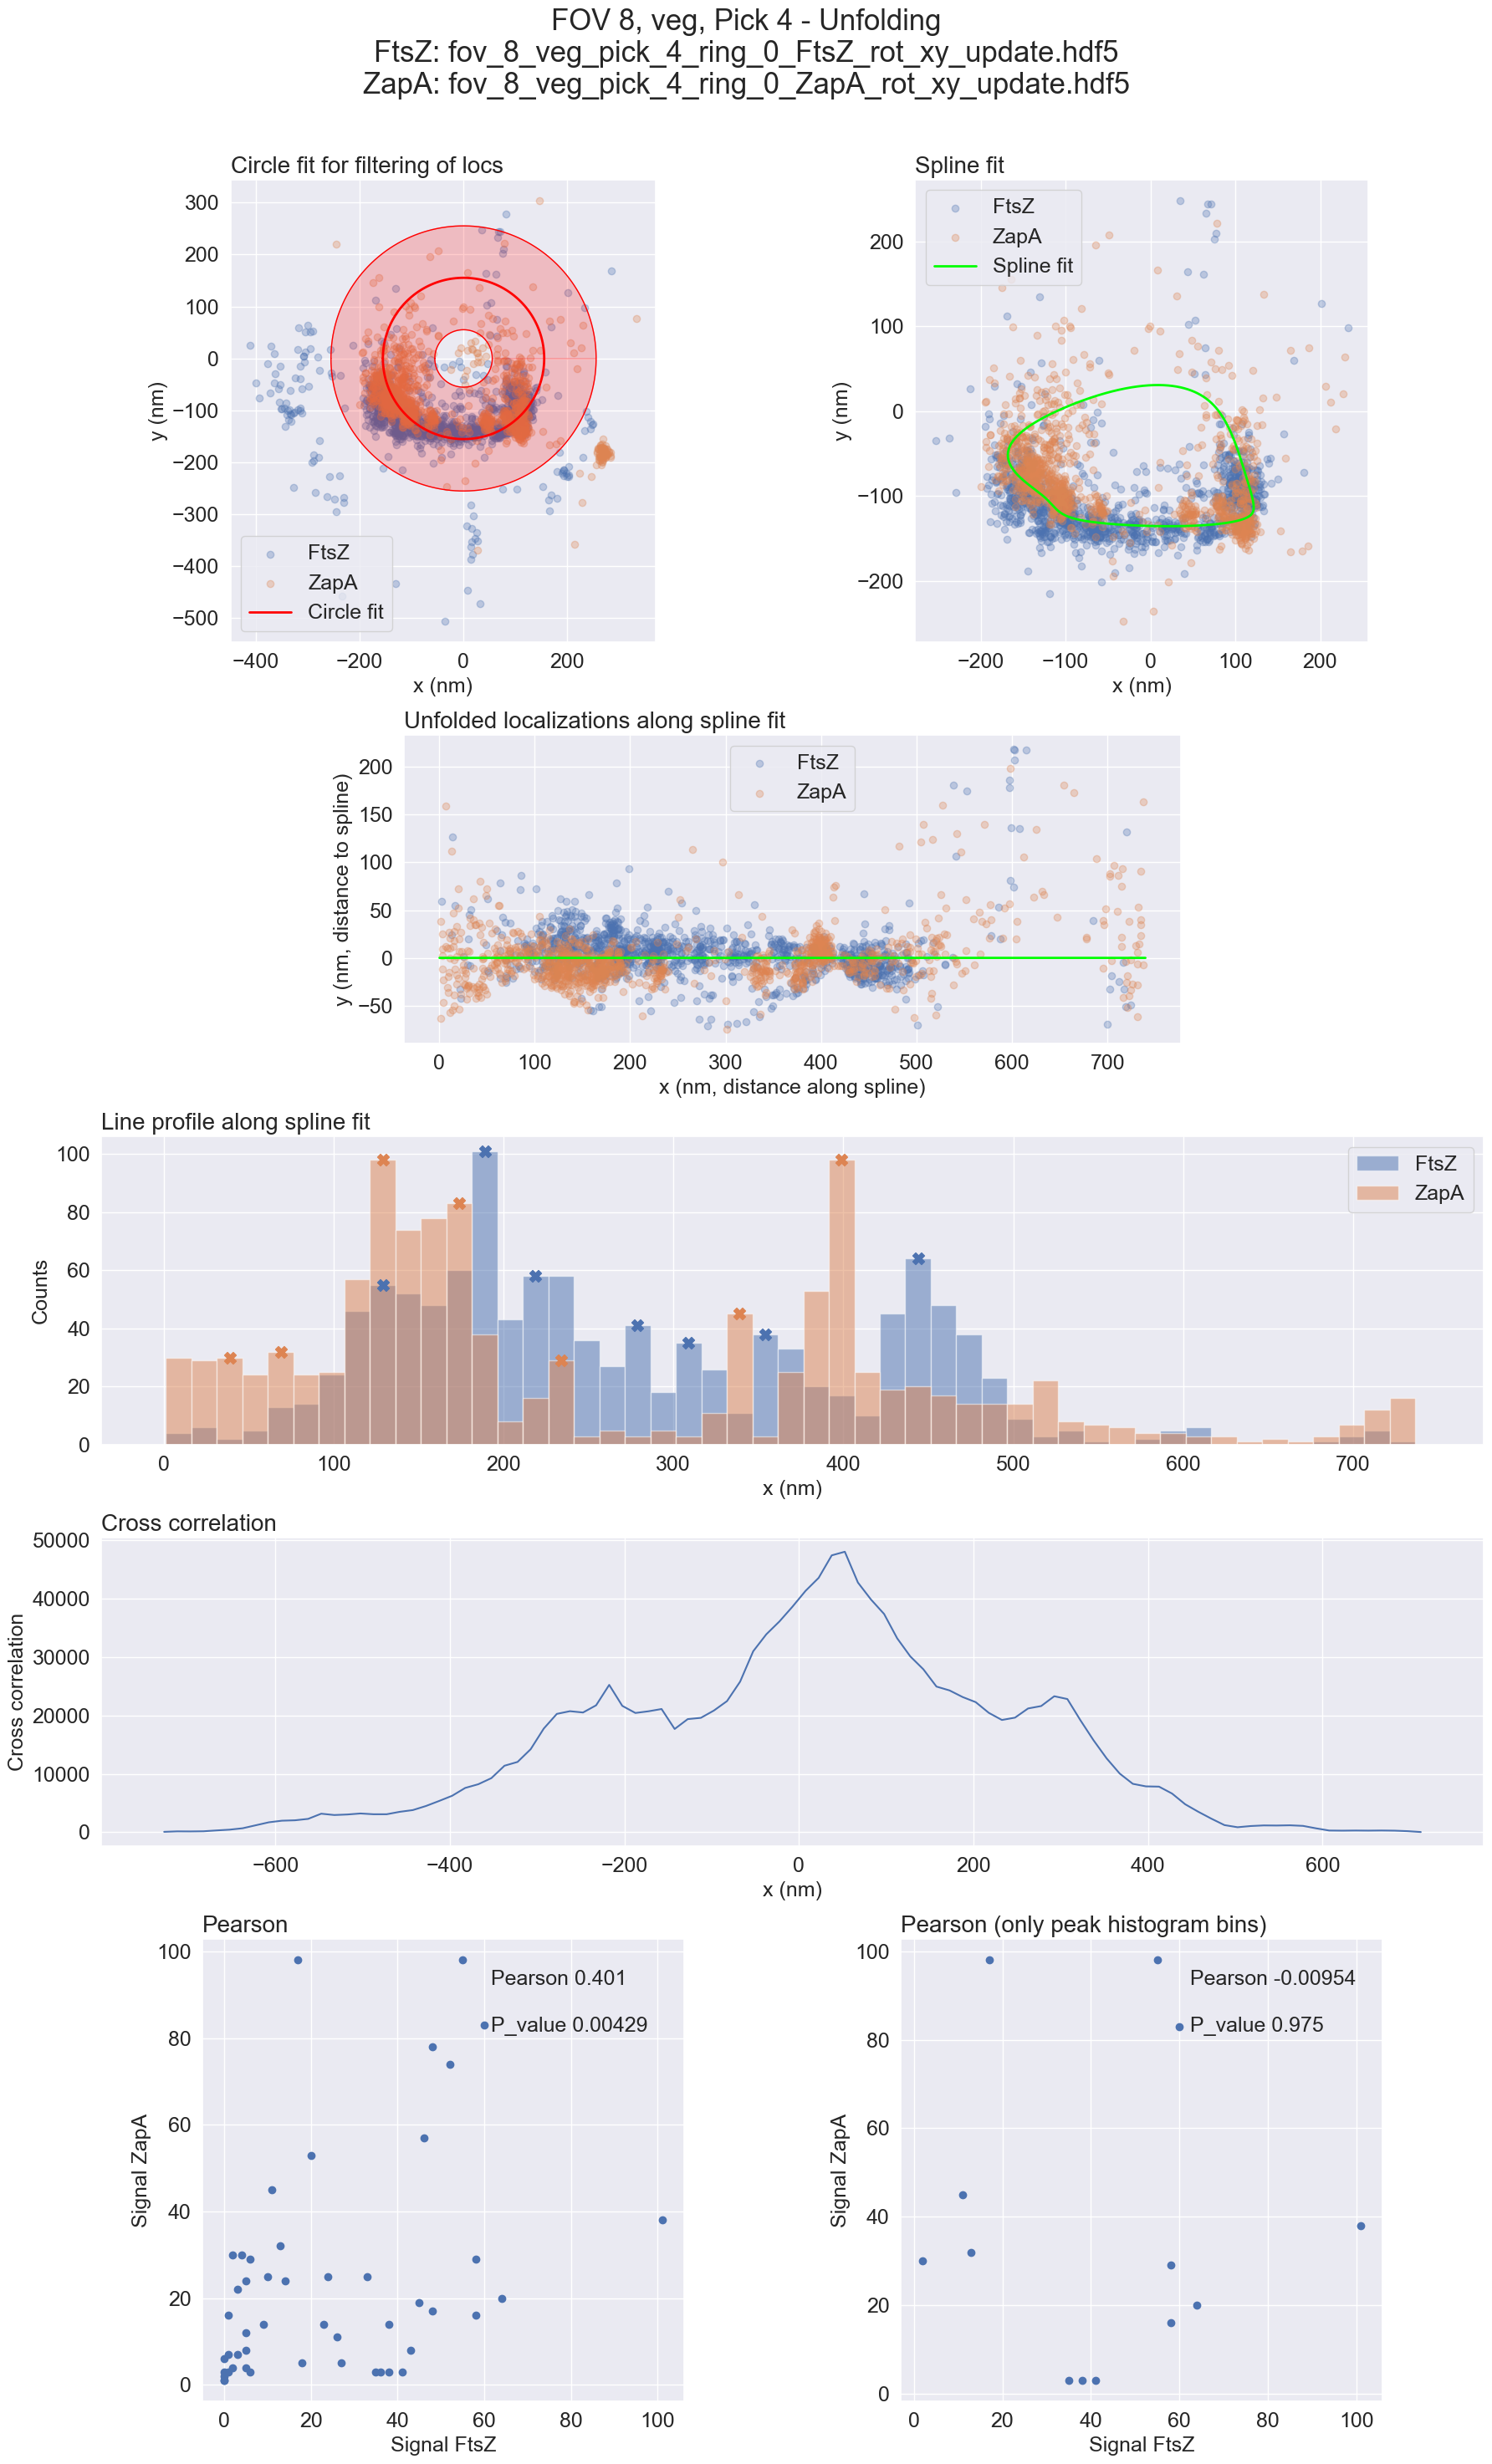

In [71]:
"""
instead of filtering the ring locs for each channel individually based on the radius determined for the respective channel
-> fit a ring to the merged locs
-> use the radius_merge for 
        - filtering out locs
        - a sanity check if the circumference matches the length of the spline
        - makes sure that the sorting by angle fits optimally (before that this was not optimally given because 
          the angles were calculated based on a different 0 for both channels)

"""

# unfolding
warnings.filterwarnings("ignore", category=RuntimeWarning) 

orientation = 'xy' # use yz, but also xy files contain info for filtering

spline_folder = os.path.join(path, 'analysis', 'unfold'+folder_suffix)
spline_folder_exclude = os.path.join(path, 'analysis', 'unfold'+folder_suffix, 'excluded_filter')

if not os.path.isdir(spline_folder):
    os.makedirs(spline_folder)
if not os.path.isdir(spline_folder_exclude):
    os.makedirs(spline_folder_exclude)
    

df_ring_data['spline_filter_passed'] = np.full(len(df_ring_data), "No")
df_ring_data['filename_ring_1'] =  'fov_' + df_ring_data['fov_id'].astype(str) +'_' + df_ring_data['cell_type'].astype(str) +'_pick_' + df_ring_data['group'].astype(str) +'_ring_' + '0_' + protein1 +'_rot_' + orientation + '_update.hdf5'
df_ring_data['filename_ring_2'] =  'fov_' + df_ring_data['fov_id'].astype(str) +'_' + df_ring_data['cell_type'].astype(str) +'_pick_' + df_ring_data['group'].astype(str) +'_ring_' + '0_' + protein2 +'_rot_' + orientation + '_update.hdf5'

for index, ring in tqdm(df_ring_data.iterrows(), desc="Processing rings", total = df_ring_data.shape[0]):

    
    #for index, ring in df_ring_data.iterrows():
    

    
    
    plt.close('all')
    
    
    locs1, info1, pixelsize = load_data(os.path.join(path, 'analysis', 'ring_locs', ring['filename_ring_1'] ))
    locs2, info2, pixelsize = load_data(os.path.join(path, 'analysis', 'ring_locs', ring['filename_ring_2'] ))


    df_locs1 = pd.DataFrame.from_records(locs1)
    df_locs2 = pd.DataFrame.from_records(locs2)
    
    
    

    
    # note: do not use the coordinates that I saved in polar coordinates!
    # why? In each channel the ring center is determined and used as the center of the coordinate system. 
    #      -> The coordinate centers differ between both channels

    
    # merge
    df_locs_merge = pd.concat([df_locs1, df_locs2])
    
    # the x and y coordinates are at the center of the FOV. Move them to be centerd around (0,0)
    dx = df_locs_merge['x'].mean()
    dy = df_locs_merge['y'].mean()
    
    df_locs_merge['x'] = df_locs_merge['x'] - dx
    df_locs_merge['y'] = df_locs_merge['y'] - dy
    
    
    # fit a ring to the merged locs

    # fit 2D ring into the YZ ring data
    x_center, y_center, radii, Radius, residu = leastsq_circle(df_locs_merge['x'], df_locs_merge['y'])

    # append radius (distance to ring center) to hdf5 file. 
    df_locs_merge['radius_merge'] = radii
    
    # calculate angle in polar coordinates for each localization                
    angles = polar_coordinate_angle(x_center, y_center, df_locs_merge['x'], df_locs_merge['y'])
    # append angle of each localization (polar coordinates with (0,0) being the ring center) to hdf5 file. 
    df_locs_merge['angle_merge'] = angles


    # move the locs to the center of the ring fit
    df_locs_merge['x'] = df_locs_merge['x'] - x_center
    df_locs_merge['y'] = df_locs_merge['y'] - y_center
    
    # radius range for filtering
    
    radius_min = Radius - dR
    radius_max = Radius + dR
    
    
    
    
    ### Graph
    
    linewidth = 2
    fontsize_main_title = 25
    fontsize_title = 20
    fontsize_text = 18
    
    
    fig = plt.figure(figsize=(18, 31)) #, constrained_layout=True
    gs = fig.add_gridspec(5,2, height_ratios=[1.5,1,1,1,1.5], width_ratios=[1,1])
    fig.suptitle(("FOV {}, {}, Pick {} - Unfolding\n"
                  "{}: {}\n"
                  "{}: {}").format(ring['fov_id'], ring['cell_type'], ring['group'], protein1, ring['filename_ring_1'], protein2, ring['filename_ring_2']),
                  fontsize=fontsize_main_title,
                  ha="center")
            
    
    # Illustrate filtering: 
    ax0 = fig.add_subplot(gs[0,0])

    # plot locs
    x1 = df_locs_merge['x'][df_locs_merge['channel'] == 1]
    y1 = df_locs_merge['y'][df_locs_merge['channel'] == 1]
    x2 = df_locs_merge['x'][df_locs_merge['channel'] == 2]
    y2 = df_locs_merge['y'][df_locs_merge['channel'] == 2]
    ax0.scatter(x1,y1, label= protein1, alpha = 0.3, color = blue);
    ax0.scatter(x2,y2, label= protein2, alpha = 0.3, color = orange);
    
    
    
    #ring of fit radius
    coords_angle_fit = np.arange(-np.pi,np.pi,0.01)
    coords_radius_fit = np.full(len(coords_angle_fit), Radius)
    coords_radius_min = np.full(len(coords_angle_fit), radius_min)
    coords_radius_max = np.full(len(coords_angle_fit), radius_max)
    
    


    # plot fitted ring and outer and innter ring
    theta_fit = np.linspace(-np.pi,np.pi, 180)
    x_fit = Radius*np.cos(theta_fit)
    y_fit = Radius*np.sin(theta_fit)
    x_rmin = radius_min*np.cos(theta_fit)
    y_rmin = radius_min*np.sin(theta_fit)
    x_rmax = radius_max*np.cos(theta_fit)
    y_rmax = radius_max*np.sin(theta_fit)
    
    ax0.plot(x_fit, y_fit, c='red', lw=2, label = 'Circle fit')
    ax0.plot(x_rmin, y_rmin, c='red', lw=1)
    ax0.plot(x_rmax, y_rmax, c='red', lw=1)
    
    
    # mark the donut area in red
    #plt.fill(x_rmax, y_rmax,'red', alpha = 0.2)
    #plt.fill(x_rmin, y_rmin,'white')
    #ax0.fill_between(x_rmax,y_rmin, y_rmax, color='red', alpha=0.2)
    radii = [radius_min, radius_max]
    theta = np.linspace(0, 2*np.pi, 180, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    ax0.fill(np.ravel(xs), np.ravel(ys), color = 'red', edgecolor='red', alpha = 0.2)
    
    
    
    
    
    ax0.set_xlabel('x (nm)', fontsize=fontsize_text)
    ax0.set_ylabel('y (nm)', fontsize=fontsize_text)
    ax0.axes.set_aspect('equal')
    ax0.set_title("Circle fit for filtering of locs",loc="left",fontsize=fontsize_title)
    ax0.tick_params(axis='x', labelsize=fontsize_text)
    ax0.tick_params(axis='y', labelsize=fontsize_text)
    ax0.legend(fontsize=fontsize_text)
    
    
    # filter
    df_locs_merge = df_locs_merge[(df_locs_merge['radius_merge']>radius_min) & (df_locs_merge['radius_merge']<radius_max)]

    
    
    
    
    
    ### sort by angle (necessary for proper spline fit)
    df_locs_merge = df_locs_merge.sort_values(by='angle_merge')
    #print('angle', df_locs_merge['angle'].min(), df_locs_merge['angle'].max(), )
    
    
    
    #theta = df_locs_merge['angle_merge']/180*np.pi
    #R = df_locs_merge['radius_merge']
    
    #x = R * np.cos(theta)
    #y = R * np.sin(theta)
    
    x = df_locs_merge['x'] 
    y = df_locs_merge['y']
    
    points = np.vstack( (x, y) ).T
    

    
    
    

    
    
    
    def interpol3D(num_true_pts, s, x_array, y_array, z_array, per = 0):
    
        tck, u = interpolate.splprep([x_array, y_array, z_array], s=s, per = per) # adding per = 1 fixed it
        # default k = 3 -> cubic spline
        
        x_knots, y_knots, z_knots = interpolate.splev(tck[0], tck)
        u_fine = np.linspace(0, 1, num_true_pts)
        x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

        return x_fine, y_fine, z_fine
    
    
    
    # interpolation parameters ###
    
    m = len(df_locs_merge)
    #s = (m-np.sqrt(2*m)) * 50**2
    s = m * 50**2 / 2
    num_true_pts = 361
    num_true_pts = 3601    
    
    
    x_fine, y_fine, z_fine, = interpol3D(num_true_pts, s, x, y, np.zeros(len(x)), per = 1)
    
    
    # Illustrate spline fit: 
    ax1 = fig.add_subplot(gs[0,1])

    # plot locs
    x1 = x[df_locs_merge['channel'] == 1]
    y1 = y[df_locs_merge['channel'] == 1]
    x2 = x[df_locs_merge['channel'] == 2]
    y2 = y[df_locs_merge['channel'] == 2]
    ax1.scatter(x1,y1, label= protein1, alpha = 0.3, color = blue);
    ax1.scatter(x2,y2, label= protein2, alpha = 0.3, color = orange);
    

    

    
    # plot fit
    #ax1.plot(x_fit, y_fit, label="Fitted circle", lw=linewidth, c=red)

    ax1.set_xlabel('x (nm)', fontsize=fontsize_text)
    ax1.set_ylabel('y (nm)', fontsize=fontsize_text)
    ax1.axes.set_aspect('equal')
    ax1.set_title("Spline fit",loc="left",fontsize=fontsize_title)
    ax1.tick_params(axis='x', labelsize=fontsize_text)
    ax1.tick_params(axis='y', labelsize=fontsize_text)
    ax1.plot(x_fine, y_fine, color = 'lime', label = 'Spline fit', linewidth = linewidth)
    ax1.legend(fontsize=fontsize_text)
    

    


    

    
    
    ### unfold
    
    # calculate distance of each datapoint to the spline
    
    #The spline consists of num_true_pts coordinates. 
    #-> Calculate the distance from a given datapoint to all spline coordinates.
    
    # search the nearest neighbor 
    nnd, idx = nearest_neighbor(
                x_fine, x, 
                y_fine, y, 
                z1 = None, z2 = None,
                nn_count = 1,
                same_channel = False)

    
    # first and last point in spline are identical
    idx[idx==idx.max()] = idx.min()
    
    
    def spline_dist(xs, ys, zs):
        # distance from one point to the next
        dist = np.sqrt((xs[1:]-xs[:-1])**2 + (ys[1:]-ys[:-1])**2 + (zs[1:]-zs[:-1])**2)
        dist_cum = np.cumsum(dist)
        
        return dist_cum
    
    dist_cum = spline_dist(x_fine, y_fine, z_fine)
    
    
    
    x_unfold = np.squeeze(dist_cum[idx])
    y_unfold = np.squeeze(nnd)
    
    
    # nnd is always positive.
    # Is the datapoint inside of the spline or outside?
    # Calculate if the datapoint or its closest point on the spline are closer to the center
    sign_bool = np.less(x**2 + y**2,np.squeeze(x_fine[idx])**2+np.squeeze(y_fine[idx])**2)
    sign = sign_bool.copy()
    sign[~sign_bool] = +1
    sign[sign_bool] = -1
    

    y_unfold = sign * y_unfold
    

    x_unfold_1 = x_unfold[df_locs_merge['channel'] == 1]
    y_unfold_1 = y_unfold[df_locs_merge['channel'] == 1]
    x_unfold_2 = x_unfold[df_locs_merge['channel'] == 2]
    y_unfold_2 = y_unfold[df_locs_merge['channel'] == 2]

    
    ax2 = fig.add_subplot(gs[1,:])
    #ax.scatter(x_unfold, y_unfold, label= 'unfolded', alpha = 0.3, color = orange);
    ax2.scatter(x_unfold_1, y_unfold_1, label = protein1, alpha = 0.3, color = blue);
    ax2.scatter(x_unfold_2, y_unfold_2, label = protein2, alpha = 0.3, color = orange);
    ax2.plot(dist_cum, np.full(len(dist_cum),0), color = 'lime', linewidth = linewidth)
    ax2.legend(fontsize=fontsize_text)
    ax2.set_xlabel('x (nm, distance along spline)', fontsize=fontsize_text)
    ax2.set_ylabel('y (nm, distance to spline)', fontsize=fontsize_text)
    ax2.axes.set_aspect('equal')
    ax2.set_title("Unfolded localizations along spline fit",loc="left",fontsize=fontsize_title)
    ax2.tick_params(axis='x', labelsize=fontsize_text)
    ax2.tick_params(axis='y', labelsize=fontsize_text)
    
    
    # histogram
    ax3 = fig.add_subplot(gs[2,:])
    
    step_size = 15 # nm
    bins = np.arange(x_unfold.min(),x_unfold.max()+step_size/2, step_size)
    centers = (bins[:-1] + bins[1:]) / 2
    binwidth = bins[1]-bins[0]

    n1, bins1 = np.histogram(x_unfold_1, bins=bins)
    n2, bins2 = np.histogram(x_unfold_2, bins=bins)


    ax3.bar(centers, n1, width=binwidth, color=blue, alpha = 0.5, label = protein1)
    ax3.bar(centers, n2, width=binwidth, color=orange, alpha = 0.5, label = protein2)
    
    
    
    # search peaks
    peak_inx_1, peak_properties_1 = find_peaks(n1, height=n1.mean())
    #peak_inx_1, peak_properties_1 = find_peaks(n1, height=n1.max()/4)
    #peak_inx_1, peak_properties_1 = find_peaks(n1, prominence = (0.2,1))
    ax3.scatter(centers[peak_inx_1], n1[peak_inx_1], marker = "X", color = blue, s = 100)
    peak_inx_2, peak_properties_2 = find_peaks(n2, height=n2.mean())
    #peak_inx_2, peak_properties_2 = find_peaks(n2, prominence = (0.2,1))
    ax3.scatter(centers[peak_inx_2], n2[peak_inx_2], marker = "X", color = orange, s = 100)
    #, width = 3
    
    
    
    ax3.set_title("Line profile along spline fit",loc="left",fontsize=fontsize_title)
    
    
    ax3.set_xlabel("x (nm)", fontsize=fontsize_text)
    ax3.set_ylabel("Counts", fontsize=fontsize_text) 
    ax3.set_xlim(ax2.get_xlim())
    #ax3.set_xticklabels(fontsize=fontsize_text)
    ax3.tick_params(axis='x', labelsize=fontsize_text)
    ax3.tick_params(axis='y', labelsize=fontsize_text)
    ax3.legend(fontsize=fontsize_text)

    
    
    ## cross correlation between histogram of protein1 and protein2
    ax4 = fig.add_subplot(gs[3,:])
    cross_corr = np.correlate(n1,n2, "full")
    x_cross_corr = np.arange(-len(cross_corr)/2,len(cross_corr)/2,1)*step_size

    ax4.plot(x_cross_corr, cross_corr)
    
    ax4.set_title("Cross correlation",loc="left",fontsize=fontsize_title)

    ax4.set_xlabel("x (nm)", fontsize=fontsize_text)
    ax4.set_ylabel("Cross correlation", fontsize=fontsize_text) 
    #ax4.set_xlim(ax2.get_xlim())
    #ax3.set_xticklabels(fontsize=fontsize_text)
    ax4.tick_params(axis='x', labelsize=fontsize_text)
    ax4.tick_params(axis='y', labelsize=fontsize_text)
    #ax4.legend(fontsize=fontsize_text)
    
    # pearson
    ax5 = fig.add_subplot(gs[4,0])

    ax5.scatter(n1, n2)
    
    ax5.set_xlabel("Signal {}".format(protein1), fontsize=fontsize_text)
    ax5.set_ylabel("Signal {}".format(protein2), fontsize=fontsize_text) 

    ax5.tick_params(axis='x', labelsize=fontsize_text)
    ax5.tick_params(axis='y', labelsize=fontsize_text)
    
    pearson, p_value = stats.pearsonr(n1,n2)
    ax5.annotate('Pearson %.03g' % pearson, (0.6,0.9), xycoords = 'axes fraction', fontsize = fontsize_text)
    ax5.annotate('P_value %.03g' % p_value, (0.6,0.8), xycoords = 'axes fraction', fontsize = fontsize_text)
    ax5.axes.set_aspect('equal')
    ax5.set_title("Pearson",loc="left",fontsize=fontsize_title)
    
    
    # pearson only on histogram bins which where marked as peaks
    ax6 = fig.add_subplot(gs[4,1])

    
    
    ax6.set_xlabel("Signal {}".format(protein1), fontsize=fontsize_text)
    ax6.set_ylabel("Signal {}".format(protein2), fontsize=fontsize_text) 

    ax6.tick_params(axis='x', labelsize=fontsize_text)
    ax6.tick_params(axis='y', labelsize=fontsize_text)
    
    peak_inx = np.unique(np.append(peak_inx_1, peak_inx_2))
    ax6.scatter(n1[peak_inx], n2[peak_inx])

    pearson_peak, p_value_peak = stats.pearsonr(n1[peak_inx],n2[peak_inx])
    ax6.annotate('Pearson %.03g' % pearson_peak, (0.6,0.9), xycoords = 'axes fraction', fontsize = fontsize_text)
    ax6.annotate('P_value %.03g' % p_value_peak, (0.6,0.8), xycoords = 'axes fraction', fontsize = fontsize_text)
    ax6.axes.set_aspect('equal')
    ax6.set_title("Pearson (only peak histogram bins)",loc="left",fontsize=fontsize_title)
    
    
    ## Filter out uggly rings:
    # criteria
    # - The length of the spline curve is much larger or smaller than the circle circumference
    # - To filter out rings that are incomplete (most likely because the imaging plane was off)
    #   I will use an approach similar to the filtering by the number of segments that we used for single channel data.
    #   For simplicity I will here define segments along the spline curve (aka segments in the histogram) and 
    #   discard a ring if too many sigments are empty
    
    
    # circumference criterion
    circumference = 2 * Radius * np.pi
    spline_length = dist_cum[-1]
    
    exclude = False
    
    if spline_length >= (1.5 * circumference):
        exclude = True
    if spline_length <= (0.5 * circumference):
        exclude = True
    
    #print('spline_length:', spline_length)
    #print('circumference:', circumference)
    #print('spline_length/circumference:', spline_length/circumference)
    
    
    # segment criterion
    
    # Sum the histogram bins of channel 1 and 2
    N_segments = 12
    perc_locs_per_filled_segment_min = 1/N_segments/4 # a segment counts as filled if it contains this fraction of all localizations
    perc_segments_filled_min = 0.6 # this fraction of segments has to be filled to accept the ring
    
    length_segment = np.ceil(len(n1) / N_segments).astype(int) # number of bins in histogram per segment
    n = n1 + n2
    locs_per_segment = np.add.reduceat(n, np.arange(0, len(n), length_segment))
    
    perc_locs_per_segment = locs_per_segment / n.sum()
    #print('perc_locs_per_segment:', perc_locs_per_segment)
    
    perc_locs_per_segments_filled = perc_locs_per_segment[perc_locs_per_segment > perc_locs_per_filled_segment_min]
    perc_segments_filled = len(perc_locs_per_segments_filled)/N_segments
    #print('perc_segments_filled:', perc_segments_filled)
    if perc_segments_filled < perc_segments_filled_min:
        exclude = True
    
    #plt.show()
    
    # save
    fig.tight_layout(rect=[0, 0.03, 1, 0.97])
    filename_save = ring['filename_ring_1'].replace(protein1, 'merge').replace('.hdf5', '_spline.png')
    
    df_ring_data.loc[index,'radius_merge'] = Radius
    df_ring_data.loc[index,'2piradius_merge'] = circumference
    df_ring_data.loc[index,'spline_length'] = spline_length
    df_ring_data.loc[index,'N_peaks1'] = len(peak_inx_1)
    df_ring_data.loc[index,'N_peaks2'] = len(peak_inx_2)
    df_ring_data.loc[index,'pearson'] = pearson
    df_ring_data.loc[index,'pearson_p_value'] = p_value
    df_ring_data.loc[index,'pearson_peak'] = pearson_peak
    df_ring_data.loc[index,'pearson_p_value_peak'] = p_value_peak

    
    if not exclude:
        df_ring_data.loc[index,'spline_filter_passed'] = 'Yes'
        fig.savefig(os.path.join(path, 'analysis', spline_folder, filename_save), dpi=300, format="png")

    else:
        df_ring_data.loc[index,'spline_filter_passed'] = 'No'
        fig.savefig(os.path.join(path, 'analysis', spline_folder_exclude, filename_save), dpi=300, format="png")
        
    
    
    
df_ring_data = df_ring_data.drop(columns=['filename_ring_1', 'filename_ring_2'])



df_ring_data.to_csv(os.path.join(path,"exchange_data_filter"+folder_suffix+".csv"))
# Save dataframe with cell means for easy loading of data for postprocessing
df_ring_data.to_pickle(os.path.join(path,"exchange_data_filter"+folder_suffix+".pkl"))



In [ ]:
df_ring_data = load_ring_data_df(path, "exchange_data.pkl")

data_veg = df_ring_data[df_ring_data['cell_type'] == 'veg']
data_spor = df_ring_data[df_ring_data['cell_type'] == 'spor']

# histogram
max_bin = max(data_veg['p2p distance'].max(), data_spor['p2p distance'].max())
min_bin = min(data_veg['p2p distance'].min(), data_spor['p2p distance'].min())

N_bins = 20
step_size = (max_bin-min_bin)/N_bins
bins = np.arange(min_bin,max_bin+1, step_size)

n_veg, bins_veg = np.histogram(data_veg['p2p distance'], bins=bins)
centers_veg = (bins[:-1] + bins[1:]) / 2

n_spor, bins_spor = np.histogram(data_spor['p2p distance'], bins=bins)
centers_spor = (bins[:-1] + bins[1:]) / 2

binwidth = bins[1]-bins[0]

fig = plt.figure()
ax = fig.add_subplot()

ax.bar(centers_spor, n_spor, width=binwidth, color=red, alpha = 0.5, label = 'spor')
ax.bar(centers_veg, n_veg, width=binwidth, color=blue, alpha = 0.5, label = 'veg')

ax.axvline(0,c='gray', linewidth=2, linestyle="--")

ax.set_title('Distance from {} to {}'.format(protein1, protein2),fontsize=14)
ax.set_xlabel("Distance (nm)")
ax.set_ylabel("Counts")  
    
ax.legend()

# ring analysis
img_fname = "Distance"
img_name = os.path.join(analysis_folder, img_fname)
fig.savefig(img_name+img_format, dpi=dpi, format="png")
plt.close(fig)